<a href="https://colab.research.google.com/github/c-e-leiva/AprendizajeAutomatico2/blob/main/RL_TP1_entorno_discreto_FrozenLake_Carlos_E_Leiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__________________________
__________________________
# **Trabajo Práctico: Aprendizaje por Refuerzo en FrozenLake**
## **Alumno:** Carlos Ezequiel Leiva
## **Profesora:** Ana Diedrichs

___________________________
__________________________

**¿Qué es FrozenLake?**

FrozenLake es un entorno clásico para Aprendizaje por Refuerzo (Reinforcement Learning, RL) disponible en la librería OpenAI Gym. Representa un lago congelado dividido en casillas donde un agente debe aprender a moverse desde un punto inicial hasta una meta evitando caer en huecos (peligros).

**¿Para qué sirve?**

Este entorno es útil para estudiar y probar algoritmos básicos de RL, ya que tiene un espacio de estados y acciones discretos y un escenario estocástico, lo que implica que el agente debe aprender a planificar y adaptarse a la incertidumbre para maximizar su recompensa.

**Ejemplos de casos de uso:**

- **Robótica:** Aprender a navegar en un entorno incierto, evitando obstáculos y riesgos.
- **Videojuegos:** Desarrollar agentes que aprendan estrategias óptimas para llegar a un objetivo en mapas simples.
- **Sistemas de recomendación:** Decidir la mejor acción para maximizar resultados futuros en entornos con incertidumbre.
- **Optimización de rutas:** Planificación de caminos seguros y eficientes cuando hay probabilidades de fallos o bloqueos.

## Instalación de librerías

En este trabajo práctico utilizaremos varias librerías para manejar el entorno FrozenLake, procesamiento numérico, visualización y construcción de modelos de aprendizaje profundo:

In [ ]:
# Importamos las librerías necesarias para el TP

import gymnasium as gym           # Entornos de Reinforcement Learning (incluye FrozenLake)
import numpy as np               # Operaciones numéricas y manejo de arrays
import matplotlib.pyplot as plt  # Visualización de gráficos
import seaborn as sns            # Gráficos estadísticos con mejor estética

import torch                     # Framework para Deep Learning
import torch.nn as nn            # Módulos para construir redes neuronales
import torch.optim as optim      # Optimizadores para entrenar las redes
import torch.nn.functional as F # Funciones útiles para redes neuronales (activaciones, pérdidas, etc.)

from collections import deque   # Estructura de datos para buffer de experiencia (replay buffer)
import random                   # Funciones para generación de números aleatorios
from IPython.display import clear_output  # Limpia la salida en notebooks para animaciones o actualizaciones dinámicas

import warnings                 # Manejo de advertencias
warnings.filterwarnings('ignore')  # Ignorar advertencias para evitar ruido en la salida

# Reproducibilidad en Experimentos con PyTorch y Gymnasium

En problemas de aprendizaje por refuerzo (y en general en experimentos con aprendizaje automático), la **reproducibilidad** es fundamental para poder comparar resultados entre distintas ejecuciones o modificaciones en el código. Sin reproducibilidad, los resultados varían debido a la aleatoriedad inherente en varias etapas del entrenamiento, lo que dificulta el análisis riguroso.

Para lograr reproducibilidad, debemos fijar las semillas (seeds) de los generadores de números aleatorios en:

- **Python nativo (`random`)**: controla funciones aleatorias generales.
- **NumPy**: usado en cálculos y generación de datos aleatorios.
- **PyTorch CPU y GPU**: controla el comportamiento aleatorio de los tensores y operaciones.
- **Entorno Gymnasium**: el entorno simula la dinámica, la semilla fija las condiciones iniciales y las acciones aleatorias que pueda contener.

Además, en PyTorch, algunas operaciones en GPU (especialmente con cuDNN) pueden ser no deterministas, lo que provoca variabilidad aun con la semilla fija. Por eso, se deben desactivar ciertas optimizaciones y forzar el uso de algoritmos deterministas:

- `torch.use_deterministic_algorithms(True)`: fuerza a PyTorch a usar solo operaciones deterministas, generando error si alguna no lo es.
- `torch.backends.cudnn.deterministic = True` y `torch.backends.cudnn.benchmark = False`: configuran cuDNN para evitar usar kernels no deterministas y para no buscar la mejor configuración dinámicamente.

El siguiente código encapsula todas estas configuraciones en una función `set_seed` para aplicarlas fácilmente antes de entrenar o evaluar.

---

In [ ]:
def set_seed(seed=42, env=None):
    """
    Configura semillas para reproducibilidad en:
    - Python nativo (random)
    - NumPy
    - PyTorch (CPU y GPU)
    - Entorno Gymnasium (si se pasa)

    Además, fuerza algoritmos deterministas en PyTorch para evitar resultados variables.

    Parámetros:
    - seed (int): número para fijar la semilla
    - env (gym.Env, opcional): entorno Gymnasium para fijar su semilla también
    """

    import random
    import numpy as np
    import torch

    # Semillas básicas
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Si hay GPU disponible, fijar semilla para CUDA y configurar cuDNN
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)  # fija semilla para todos los dispositivos CUDA
        torch.backends.cudnn.deterministic = True  # fuerza algoritmos deterministas en cuDNN
        torch.backends.cudnn.benchmark = False     # evita búsqueda dinámica de kernels que rompe reproducibilidad

    # Forzar PyTorch a usar solo algoritmos deterministas (en CPU y GPU)
    torch.use_deterministic_algorithms(True)

    # Fijar semilla en entorno Gym si fue pasado
    if env is not None:
        env.reset(seed=seed)  # reinicia entorno con semilla fija
        if hasattr(env, "action_space"):
            env.action_space.seed(seed)
        if hasattr(env, "observation_space"):
            env.observation_space.seed(seed)

In [ ]:
# Fijamos las semillas para asegurar reproducibilidad de resultados

#np.random.seed(42)          # Semilla para numpy (operaciones numéricas y generación aleatoria)
#torch.manual_seed(42)       # Semilla para PyTorch (redes neuronales y operaciones aleatorias)
#random.seed(42)             # Semilla para el módulo random de Python (funciones aleatorias generales)

## Creación del entorno FrozenLake

En este bloque creamos el entorno FrozenLake con el mapa clásico de 4x4 casillas. La opción `is_slippery=True` indica que el movimiento es estocástico, es decir, el agente puede resbalar y no siempre moverse en la dirección deseada. Se muestra información básica del entorno como la cantidad de estados, acciones disponibles y el significado de cada acción.

In [ ]:
# Creamos el entorno FrozenLake con el mapa 4x4 y dinámica resbaladiza (stochastic)
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='ansi')

# Fijamos la semilla para asegurar reproducibilidad en numpy, torch, random y el entorno gym
# Esto garantiza que las ejecuciones sean consistentes y comparables
set_seed(seed=42, env=env)


print("🏔️ ENTORNO FROZENLAKE")
print("=" * 50)
print(f"Número de estados: {env.observation_space.n}")  # Total de posiciones o estados posibles
print(f"Número de acciones: {env.action_space.n}")      # Total de acciones posibles (4 direcciones)
print(f"Acciones: {['Izquierda', 'Abajo', 'Derecha', 'Arriba']}")  # Significado de cada acción

🏔️ ENTORNO FROZENLAKE
Número de estados: 16
Número de acciones: 4
Acciones: ['Izquierda', 'Abajo', 'Derecha', 'Arriba']


## Mostrar el mapa del entorno

En este bloque mostramos la representación visual del mapa FrozenLake. Cada casilla puede ser:

- **S**: Punto de inicio.
- **F**: Hielo seguro donde el agente puede caminar.
- **H**: Hoyo, que termina el episodio si el agente cae.
- **G**: Objetivo o meta, que otorga recompensa positiva.

In [ ]:
# Mostrar el mapa del entorno FrozenLake

print("\n🗺️ MAPA DEL ENTORNO:")  # Título para indicar que se mostrará el mapa
env.reset()                      # Reinicia el entorno para asegurar que esté en estado inicial
print(env.render())              # Muestra la representación textual del mapa actual

print("\nLeyenda:")             # Título para explicar qué significa cada símbolo en el mapa
print("S = Start (Inicio)")      # S: Casilla de inicio donde comienza el agente
print("F = Frozen (Hielo seguro)")  # F: Casilla segura donde el agente puede caminar sin peligro
print("H = Hole (Hoyo - termina episodio)")  # H: Hoyo, si el agente cae aquí, termina el episodio
print("G = Goal (Objetivo - +1 recompensa)")  # G: Meta que da recompensa positiva y termina el episodio


🗺️ MAPA DEL ENTORNO:

SFFF
FHFH
FFFH
HFFG


Leyenda:
S = Start (Inicio)
F = Frozen (Hielo seguro)
H = Hole (Hoyo - termina episodio)
G = Goal (Objetivo - +1 recompensa)


## Función para convertir estado numérico a posición (fila, columna)

En FrozenLake, cada estado es representado como un número entero que corresponde a una casilla en el mapa linealizado. Esta función convierte ese número en una posición bidimensional (fila, columna) para facilitar la interpretación y visualización en la cuadrícula 4x4.

In [ ]:
def estado_a_posicion(estado):
    """
    Convierte un estado entero a coordenadas (fila, columna)
    en el mapa 4x4 de FrozenLake.

    Parámetros:
    estado (int): índice del estado (0 a 15)

    Retorna:
    tuple: (fila, columna) correspondiente en la cuadrícula
    """
    fila = estado // 4      # División entera para obtener la fila
    columna = estado % 4    # Módulo para obtener la columna
    return fila, columna

## Función para visualizar una política

Esta función recibe una política representada como un array de acciones (0 a 3) para cada estado del mapa FrozenLake, y la visualiza en una cuadrícula 4x4.

Cada acción se muestra como una flecha que indica la dirección que el agente debería tomar desde esa casilla. Además, se etiquetan las casillas especiales:

- **S**: Start (inicio)  
- **G**: Goal (objetivo)  
- **H**: Holes (hoyos, peligro)  

Esta visualización ayuda a interpretar fácilmente el comportamiento de la política aprendida o definida.

In [ ]:
def visualizar_politica(policy, title="Política"):
    """
    Visualiza la política en un mapa 4x4 del entorno FrozenLake.

    Parámetros:
    policy (array): array de enteros (0-3) con la acción para cada estado
    title (str): título para el gráfico

    Acciones: 0=Izquierda, 1=Abajo, 2=Derecha, 3=Arriba
    """

    acciones_simbolos = ['←', '↓', '→', '↑']  # Símbolos para representar acciones
    grid = np.array(acciones_simbolos)[policy].reshape(4, 4)  # Convertir política a símbolos en 4x4

    plt.figure(figsize=(6, 6))
    plt.imshow(np.ones((4, 4)), cmap='Blues', alpha=0.3)  # Fondo azul claro para el mapa

    for i in range(4):
        for j in range(4):
            estado = i * 4 + j

            # Etiquetar casillas especiales con símbolo y estilo distinto
            if estado == 0:  # Start
                plt.text(j, i, f'S\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold')
            elif estado == 15:  # Goal
                plt.text(j, i, f'G\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold')
            elif estado in [5, 7, 11, 12]:  # Holes
                plt.text(j, i, f'H\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold', color='red')
            else:
                plt.text(j, i, grid[i,j], ha='center', va='center', fontsize=16)

    plt.xlim(-0.5, 3.5)  # Limites del gráfico para que encaje bien
    plt.ylim(-0.5, 3.5)
    plt.xticks([])        # Ocultar ticks eje x
    plt.yticks([])        # Ocultar ticks eje y
    plt.title(title, fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.show()

## Política Aleatoria

Esta clase define una política simple que selecciona acciones completamente al azar, sin aprendizaje ni estrategia.

Se utiliza como línea base para comparar otras políticas más inteligentes o entrenadas.

El método `entrenar` ejecuta varios episodios en el entorno para evaluar su desempeño midiendo la tasa de éxito y la recompensa promedio, sin modificar la política (ya que es aleatoria).

In [ ]:
class PoliticaAleatoria:
    """Política que selecciona acciones completamente al azar"""

    def __init__(self, n_acciones):
        self.n_acciones = n_acciones
        self.nombre = "Política Aleatoria"

    def seleccionar_accion(self, estado):
        """
        Selecciona una acción aleatoria para el estado dado.

        Parámetros:
        estado (int): estado actual (no se usa en esta política)

        Retorna:
        int: acción seleccionada aleatoriamente
        """
        return np.random.randint(self.n_acciones)

    def entrenar(self, env, episodios=1000):
        """
        Evalúa la política aleatoria en el entorno durante una cantidad dada de episodios.

        Parámetros:
        env: entorno de OpenAI Gym
        episodios (int): cantidad de episodios para evaluación

        Retorna:
        tuple: lista de recompensas totales por episodio y tasa de éxito final
        """
        print(f"🎲 Evaluando {self.nombre}...")
        recompensas = []
        exitos = 0

        for episodio in range(episodios):
            estado, _ = env.reset()
            recompensa_total = 0
            terminado = False
            pasos = 0

            while not terminado and pasos < 100:
                accion = self.seleccionar_accion(estado)
                estado, recompensa, terminado, truncated, _ = env.step(accion)
                recompensa_total += recompensa
                pasos += 1

                if truncated:
                    terminado = True

            if recompensa_total > 0:
                exitos += 1
            recompensas.append(recompensa_total)

            if (episodio + 1) % 200 == 0:
                tasa_exito = exitos / (episodio + 1)
                print(f"Episodio {episodio + 1}: Tasa de éxito = {tasa_exito:.3f}")

        tasa_exito_final = exitos / episodios
        print(f"\n📊 Resultados {self.nombre}:")
        print(f"Tasa de éxito final: {tasa_exito_final:.3f}")
        print(f"Recompensa promedio: {np.mean(recompensas):.3f}")

        return recompensas, tasa_exito_final

## Crear y evaluar la política aleatoria

En este bloque creamos una instancia de la política aleatoria con el número de acciones del entorno y la evaluamos durante 1000 episodios.

Se obtienen las recompensas y la tasa de éxito para analizar su desempeño como línea base antes de implementar políticas más sofisticadas.

In [ ]:
set_seed(seed=42, env=env)  # Fijamos semilla para garantizar reproducibilidad en este bloque
# Crear una instancia de la política aleatoria con el número de acciones del entorno
agente_aleatorio = PoliticaAleatoria(env.action_space.n)

# Evaluar la política en 1000 episodios y guardar recompensas y tasa de éxito
recompensas_aleatorio, tasa_exito_aleatorio = agente_aleatorio.entrenar(env, episodios=1000)

🎲 Evaluando Política Aleatoria...
Episodio 200: Tasa de éxito = 0.020
Episodio 400: Tasa de éxito = 0.015
Episodio 600: Tasa de éxito = 0.013
Episodio 800: Tasa de éxito = 0.013
Episodio 1000: Tasa de éxito = 0.010

📊 Resultados Política Aleatoria:
Tasa de éxito final: 0.010
Recompensa promedio: 0.010


## Visualizar política aleatoria (acciones con igual probabilidad)

Para ilustrar, generamos una política aleatoria asignando una acción aleatoria a cada uno de los 16 estados del entorno.

Luego, utilizamos la función `visualizar_politica` para mostrar esta política con flechas que indican la acción asignada en cada casilla.

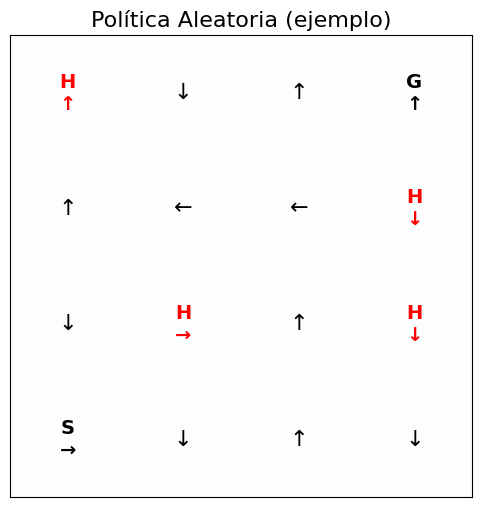

In [ ]:
# Generar una política aleatoria con acciones entre 0 y 3 para cada uno de los 16 estados

politica_aleatoria = np.random.randint(0, 4, 16)  # Array de tamaño 16 con acciones aleatorias

# Visualizar la política generada con la función de visualización creada antes
visualizar_politica(politica_aleatoria, "Política Aleatoria (ejemplo)")

## Política Q-Learning Tabular

Esta clase implementa un agente de Q-Learning con una tabla explícita `q_table` que almacena valores Q para cada estado y acción.

El agente utiliza la política epsilon-greedy para balancear exploración y explotación durante el entrenamiento.

- **Parámetros clave:**
  - `lr` (learning rate): velocidad de actualización de la tabla Q.
  - `gamma`: factor de descuento para futuras recompensas.
  - `epsilon`: probabilidad inicial de explorar (seleccionar acción aleatoria).
  - `epsilon_decay`: tasa de disminución de epsilon por episodio.
  
El método `entrenar` realiza iteraciones en el entorno actualizando la tabla Q.

El método `evaluar` prueba la política aprendida sin exploración para medir su desempeño real.

In [ ]:
import numpy as np
from collections import deque

class QLearningTabular:
    """Implementación de Q-Learning con tabla Q explícita"""

    def __init__(self, n_estados, n_acciones, lr=0.1, gamma=0.95, epsilon=1.0):
        self.n_estados = n_estados
        self.n_acciones = n_acciones
        self.lr = lr  # tasa de aprendizaje
        self.gamma = gamma  # factor de descuento
        self.epsilon = epsilon  # exploración inicial (probabilidad de acción aleatoria)
        self.epsilon_decay = 0.995  # tasa de disminución de epsilon por episodio
        self.epsilon_min = 0.01  # epsilon mínimo para evitar desaparición total de exploración
        self.nombre = "Q-Learning Tabular"

        # Inicializar tabla Q con ceros
        self.q_table = np.zeros((n_estados, n_acciones))

        # Listas para seguimiento de recompensas y epsilon a lo largo del entrenamiento
        self.recompensas_entrenamiento = []
        self.epsilons = []

    def seleccionar_accion(self, estado, entrenando=True):
        """Selecciona acción usando política epsilon-greedy"""
        if entrenando and np.random.random() < self.epsilon:
            return np.random.randint(self.n_acciones)  # Exploración: acción aleatoria
        else:
            return np.argmax(self.q_table[estado])  # Explotación: acción con mayor valor Q

    def actualizar_q(self, estado, accion, recompensa, siguiente_estado, terminado):
        """Actualiza la tabla Q según la ecuación de Bellman"""
        if terminado:
            target = recompensa  # Si terminó episodio, no se considera valor futuro
        else:
            target = recompensa + self.gamma * np.max(self.q_table[siguiente_estado])  # Valor esperado futuro

        # Actualización incremental de Q
        self.q_table[estado, accion] += self.lr * (target - self.q_table[estado, accion])

    def decay_epsilon(self):
        """Disminuye epsilon gradualmente para reducir exploración"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def obtener_politica(self):
        """Retorna la política greedy derivada de la tabla Q"""
        return np.argmax(self.q_table, axis=1)

    def entrenar(self, env, episodios=10000):
        """Entrena el agente Q-Learning en el entorno dado"""
        print(f"🧠 Entrenando {self.nombre}...")

        recompensas = []
        exitos_ventana = deque(maxlen=100)  # Para promedio móvil de éxitos recientes

        for episodio in range(episodios):
            estado, _ = env.reset()
            recompensa_total = 0
            terminado = False
            pasos = 0

            while not terminado and pasos < 100:
                accion = self.seleccionar_accion(estado, entrenando=True)
                siguiente_estado, recompensa, terminado, truncated, _ = env.step(accion)

                if truncated:
                    terminado = True

                self.actualizar_q(estado, accion, recompensa, siguiente_estado, terminado)

                recompensa_total += recompensa
                estado = siguiente_estado
                pasos += 1

            recompensas.append(recompensa_total)
            exitos_ventana.append(1 if recompensa_total > 0 else 0)
            self.epsilons.append(self.epsilon)

            self.decay_epsilon()

            if (episodio + 1) % 1000 == 0:
                tasa_exito = np.mean(exitos_ventana) if len(exitos_ventana) > 0 else 0
                print(f"Episodio {episodio + 1}: Tasa éxito (últimos 100) = {tasa_exito:.3f}, Epsilon = {self.epsilon:.3f}")

        self.recompensas_entrenamiento = recompensas
        print(f"\n✅ Entrenamiento {self.nombre} completado!")

        return recompensas

    def evaluar(self, env, episodios=100):
        """Evalúa la política aprendida sin exploración"""
        print(f"📊 Evaluando {self.nombre}...")

        exitos = 0
        recompensas = []
        pasos_totales = []

        for _ in range(episodios):
            estado, _ = env.reset()
            recompensa_total = 0
            terminado = False
            pasos = 0

            while not terminado and pasos < 100:
                accion = self.seleccionar_accion(estado, entrenando=False)  # Solo explotación
                estado, recompensa, terminado, truncated, _ = env.step(accion)

                if truncated:
                    terminado = True

                recompensa_total += recompensa
                pasos += 1

            if recompensa_total > 0:
                exitos += 1
            recompensas.append(recompensa_total)
            pasos_totales.append(pasos)

        tasa_exito = exitos / episodios
        print(f"Tasa de éxito: {tasa_exito:.3f}")
        print(f"Pasos promedio: {np.mean(pasos_totales):.1f}")

        return tasa_exito, recompensas

## Crear y entrenar agente Q-Learning

En este bloque instanciamos el agente Q-Learning tabular con los parámetros deseados:

- `lr=0.1`: tasa de aprendizaje.
- `gamma=0.95`: factor de descuento.
- `epsilon=1.0`: exploración inicial completa.

Luego, entrenamos el agente en el entorno FrozenLake durante 1000 episodios para que aprenda una política óptima.

In [ ]:
set_seed(seed=42, env=env)  # Fijamos semilla para garantizar reproducibilidad en este bloque
# Crear agente Q-Learning con parámetros definidos
agente_qlearning = QLearningTabular(
    env.observation_space.n,  # Número total de estados del entorno
    env.action_space.n,       # Número total de acciones posibles
    lr=0.1,                  # Tasa de aprendizaje
    gamma=0.95,              # Factor de descuento
    epsilon=1.0              # Valor inicial de epsilon (exploración total)
)

# Entrenar agente durante 1000 episodios en el entorno FrozenLake
recompensas_qlearning = agente_qlearning.entrenar(env, episodios=1000)

🧠 Entrenando Q-Learning Tabular...
Episodio 1000: Tasa éxito (últimos 100) = 0.090, Epsilon = 0.010

✅ Entrenamiento Q-Learning Tabular completado!


## Evaluar agente entrenado

En este bloque evaluamos el desempeño del agente Q-Learning ya entrenado en el entorno FrozenLake.

Realizamos 1000 episodios sin exploración (epsilon=0), para medir la tasa de éxito con la política aprendida.

In [ ]:
#set_seed(seed=42, env=env)  # Fijamos semilla para garantizar reproducibilidad en este bloque
# Evaluar agente Q-Learning entrenado en 1000 episodios sin exploración
tasa_exito_qlearning, _ = agente_qlearning.evaluar(env, episodios=1000)

# Imprimir la tasa de éxito final obtenida
print(f"\nTasa de éxito del agente Q-Learning: {tasa_exito_qlearning:.3f}")

📊 Evaluando Q-Learning Tabular...
Tasa de éxito: 0.095
Pasos promedio: 11.3

Tasa de éxito del agente Q-Learning: 0.095


## Visualizar política aprendida

En este bloque extraemos la política greedy aprendida por el agente Q-Learning y la visualizamos.

La política muestra la mejor acción a tomar en cada estado según el aprendizaje.

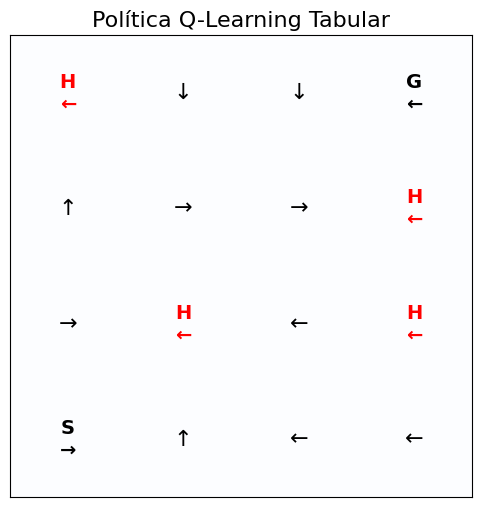

In [ ]:
# Obtener la política greedy a partir de la tabla Q (acción con mayor valor Q en cada estado)
politica_qlearning = agente_qlearning.obtener_politica()

# Visualizar la política aprendida usando símbolos para cada acción en el mapa 4x4
visualizar_politica(politica_qlearning, "Política Q-Learning Tabular")

## Visualizar tabla Q como heatmap

Este bloque genera un mapa de calor (heatmap) de la tabla Q aprendida por el agente.

Cada fila representa un estado, y cada columna una acción. Los valores indican la estimación del valor Q para esa pareja estado-acción.

Esto ayuda a entender qué acciones se valoran más en cada estado según el aprendizaje.

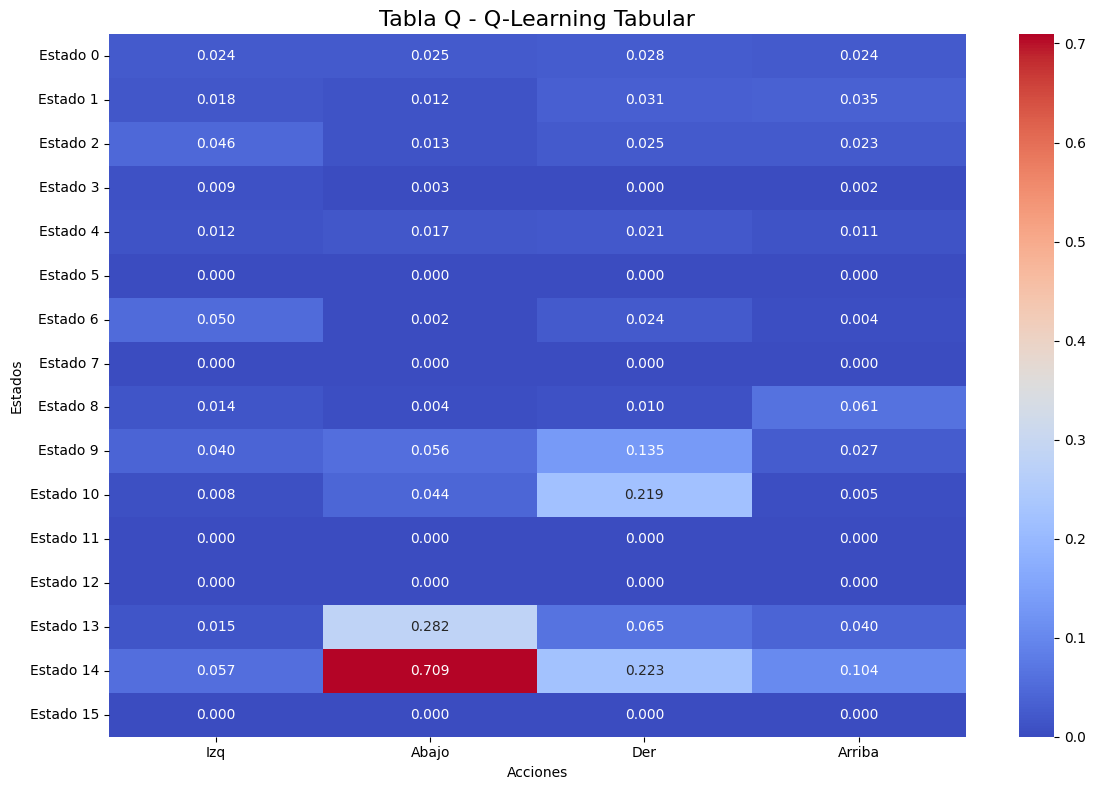

In [ ]:
# Crear figura para visualizar la tabla Q como heatmap
plt.figure(figsize=(12, 8))

# Graficar heatmap con anotaciones de valores Q (formato 3 decimales)
sns.heatmap(
    agente_qlearning.q_table,
    annot=True,             # Mostrar valores numéricos en cada celda
    fmt='.3f',              # Formato con 3 decimales
    cmap='coolwarm',        # Paleta de colores
    xticklabels=['Izq', 'Abajo', 'Der', 'Arriba'],    # Nombres de acciones en columnas
    yticklabels=[f'Estado {i}' for i in range(16)]    # Nombres de estados en filas
)

# Configuraciones de etiquetas y título
plt.title('Tabla Q - Q-Learning Tabular', fontsize=16)
plt.xlabel('Acciones')
plt.ylabel('Estados')
plt.tight_layout()
plt.show()

## Mostrar valores Q para estados importantes

Este bloque imprime los valores Q aprendidos para estados clave del entorno FrozenLake, incluyendo el inicio, los hoyos y el objetivo.

Así podemos ver qué acciones son preferidas o valoradas en cada uno de estos estados críticos.

In [ ]:
print("🎯 VALORES Q PARA ESTADOS CLAVE:")
print("-" * 40)

# Lista de estados importantes: start (0), holes (5,7,11,12), goal (15), y otro estado normal (14)
estados_clave = [0, 5, 7, 11, 12, 14, 15]

acciones_nombres = ['Izquierda', 'Abajo', 'Derecha', 'Arriba']

for estado in estados_clave:
    if estado == 0:
        tipo = "START"
    elif estado == 15:
        tipo = "GOAL"
    elif estado in [5, 7, 11, 12]:
        tipo = "HOLE"
    else:
        tipo = "NORMAL"

    print(f"\nEstado {estado} ({tipo}):")
    for accion, valor in enumerate(agente_qlearning.q_table[estado]):
        print(f"  {acciones_nombres[accion]}: {valor:.3f}")

🎯 VALORES Q PARA ESTADOS CLAVE:
----------------------------------------

Estado 0 (START):
  Izquierda: 0.024
  Abajo: 0.025
  Derecha: 0.028
  Arriba: 0.024

Estado 5 (HOLE):
  Izquierda: 0.000
  Abajo: 0.000
  Derecha: 0.000
  Arriba: 0.000

Estado 7 (HOLE):
  Izquierda: 0.000
  Abajo: 0.000
  Derecha: 0.000
  Arriba: 0.000

Estado 11 (HOLE):
  Izquierda: 0.000
  Abajo: 0.000
  Derecha: 0.000
  Arriba: 0.000

Estado 12 (HOLE):
  Izquierda: 0.000
  Abajo: 0.000
  Derecha: 0.000
  Arriba: 0.000

Estado 14 (NORMAL):
  Izquierda: 0.057
  Abajo: 0.709
  Derecha: 0.223
  Arriba: 0.104

Estado 15 (GOAL):
  Izquierda: 0.000
  Abajo: 0.000
  Derecha: 0.000
  Arriba: 0.000


# Deep Q-Network

## Red neuronal DQN (Deep Q-Network)

Esta clase define la arquitectura de la red neuronal utilizada para aproximar la función Q en Deep Q-Learning.

- La red recibe un vector de entrada con el estado (input_size).
- Tiene dos capas ocultas con activación ReLU para mayor capacidad de representación.
- La salida es un vector con un valor Q para cada acción posible (output_size).
- Esta aproximación permite manejar espacios de estado grandes o continuos.

In [ ]:
class DQN(nn.Module):
    """Red neuronal para aproximar la función Q"""
    def __init__(self, input_size, hidden_size, output_size):
        super(DQN, self).__init__()

        # Definición de la red secuencial con dos capas ocultas y ReLU
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),  # Capa de entrada a oculta
            nn.ReLU(),                          # Activación no lineal ReLU
            nn.Linear(hidden_size, hidden_size),# Segunda capa oculta
            nn.ReLU(),
            nn.Linear(hidden_size, output_size) # Capa de salida con valores Q para cada acción
        )

    def forward(self, x):
        # Propagación hacia adelante
        return self.network(x)

## DQNAgent

Este bloque define la clase `DQNAgent`, un agente basado en Deep Q-Network (DQN) para aprendizaje por refuerzo. Implementa una red neuronal que aproxima la función Q, usa Experience Replay para entrenar con muestras aleatorias y una Target Network para estabilizar el aprendizaje. Incluye mecanismos de exploración-explotación mediante una política epsilon-greedy, y funciones para entrenar, evaluar y obtener la política óptima aprendida. La clase también maneja el descenso gradual de la exploración (decay de epsilon) y actualiza periódicamente la target network para mejorar la estabilidad del entrenamiento.

In [ ]:
class DQNAgent:
    """Agente Deep Q-Network con Experience Replay y Target Network"""
    def __init__(self, state_size, action_size, lr=0.001, gamma=0.95, epsilon=1.0):
        # Inicialización de parámetros del agente
        self.state_size = state_size  # Número total de estados discretos posibles
        self.action_size = action_size  # Número de acciones posibles en el entorno
        self.gamma = gamma  # Factor de descuento para futuras recompensas (0 < gamma < 1)
        self.epsilon = epsilon  # Probabilidad inicial de explorar (elegir acción aleatoria)
        self.epsilon_decay = 0.995  # Factor multiplicativo para reducir epsilon tras cada episodio
        self.epsilon_min = 0.01  # Valor mínimo que puede tomar epsilon para mantener algo de exploración
        self.learning_rate = lr  # Tasa de aprendizaje para el optimizador
        self.nombre = "Deep Q-Network (DQN)"  # Nombre del agente para logs

        # Detectar si hay GPU disponible y usarla, sino CPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"🖥️ Usando dispositivo: {self.device}")

        # Definir el tamaño de las capas ocultas en la red neuronal
        hidden_size = 128

        # Crear la red principal (q_network) que aprenderá la función Q
        self.q_network = DQN(state_size, hidden_size, action_size).to(self.device)

        # Crear la target network que se usa para estabilizar el aprendizaje
        self.target_network = DQN(state_size, hidden_size, action_size).to(self.device)

        # Configurar el optimizador Adam para ajustar pesos de la q_network
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        # Inicializar la target network con los mismos pesos que la q_network
        self.update_target_network()

        # Buffer para guardar las experiencias en forma de tuplas (estado, acción, recompensa, siguiente_estado, terminado)
        self.memory = deque(maxlen=10000)  # Máximo 10,000 experiencias almacenadas

        # Tamaño del batch que se usará para el entrenamiento por experiencia repetida
        self.batch_size = 32

        # Frecuencia (en pasos) con la que se actualiza la target network
        self.update_target_frequency = 100

        # Contador global de pasos tomados (acciones ejecutadas)
        self.step_count = 0

        # Listas para registrar métricas del entrenamiento (pérdida, recompensas y epsilon)
        self.losses = []
        self.recompensas_entrenamiento = []
        self.epsilons = []

    def state_to_onehot(self, state):
        """Convierte el estado entero a vector one-hot para alimentar la red"""
        onehot = np.zeros(self.state_size)  # Inicializar vector de ceros
        onehot[state] = 1.0  # Poner 1 en la posición del estado actual
        return onehot

    def remember(self, estado, accion, recompensa, siguiente_estado, terminado):
        """Almacena la experiencia actual en el buffer de replay"""
        # Convertir estados a formato one-hot
        estado_onehot = self.state_to_onehot(estado)
        siguiente_estado_onehot = self.state_to_onehot(siguiente_estado)
        # Agregar la experiencia al buffer
        self.memory.append((estado_onehot, accion, recompensa, siguiente_estado_onehot, terminado))

    def seleccionar_accion(self, estado, entrenando=True):
        """
        Selección de acción usando política epsilon-greedy:
        - Con probabilidad epsilon se elige acción aleatoria (exploración)
        - Sino, se usa la red neuronal para elegir la acción con mayor valor Q (explotación)
        """
        if entrenando and np.random.random() < self.epsilon:
            # Acción aleatoria
            return random.randrange(self.action_size)

        # Convertir el estado a tensor para la red
        estado_onehot = self.state_to_onehot(estado)
        estado_tensor = torch.FloatTensor(estado_onehot).unsqueeze(0).to(self.device)  # Añadir dimensión batch

        # Forward pass en modo evaluación (sin calcular gradientes)
        with torch.no_grad():
            q_values = self.q_network(estado_tensor)

        # Seleccionar la acción con el mayor valor Q predicho
        return np.argmax(q_values.cpu().data.numpy())

    def replay(self):
        """
        Entrenamiento del agente con Experience Replay:
        - Se extrae un batch aleatorio de experiencias del buffer
        - Se calcula la pérdida entre Q actual y Q objetivo
        - Se actualizan los pesos de la red neuronal principal
        """
        # No entrenar si no hay suficientes experiencias almacenadas
        if len(self.memory) < self.batch_size:
            return

        # Muestrear batch aleatorio de experiencias
        batch = random.sample(self.memory, self.batch_size)

        # Separar componentes del batch y convertirlos a tensores para PyTorch
        estados = torch.FloatTensor([e[0] for e in batch]).to(self.device)
        acciones = torch.LongTensor([e[1] for e in batch]).to(self.device)
        recompensas = torch.FloatTensor([e[2] for e in batch]).to(self.device)
        siguientes_estados = torch.FloatTensor([e[3] for e in batch]).to(self.device)
        terminados = torch.BoolTensor([e[4] for e in batch]).to(self.device)

        # Obtener valores Q actuales para las acciones tomadas (q_network)
        current_q_values = self.q_network(estados).gather(1, acciones.unsqueeze(1))

        # Calcular valores Q objetivo usando la target network para estabilidad
        with torch.no_grad():
            next_q_values = self.target_network(siguientes_estados).max(1)[0]
        target_q_values = recompensas + (self.gamma * next_q_values * ~terminados)

        # Calcular la pérdida como error cuadrático medio entre actuales y objetivos
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

        # Propagación hacia atrás y actualización de pesos
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Registrar la pérdida para análisis posterior
        self.losses.append(loss.item())

    def update_target_network(self):
        """Actualiza la target network copiando los pesos de la red principal"""
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        """Reduce epsilon para disminuir la exploración a medida que avanza el entrenamiento"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def obtener_politica(self):
        """
        Obtiene la política final del agente:
        Para cada estado devuelve la acción con mayor valor Q (política greedy)
        """
        politica = []
        for estado in range(self.state_size):
            accion = self.seleccionar_accion(estado, entrenando=False)
            politica.append(accion)
        return np.array(politica)

    def entrenar(self, env, episodios=2000):
        """Entrena el agente en el entorno durante una cantidad dada de episodios"""
        print(f"🤖 Entrenando {self.nombre}...")

        recompensas = []
        exitos_ventana = deque(maxlen=100)

        for episodio in range(episodios):
            # Reiniciar entorno para nuevo episodio
            estado, _ = env.reset()
            recompensa_total = 0
            terminado = False
            pasos = 0

            while not terminado and pasos < 100:
                # Elegir acción epsilon-greedy
                accion = self.seleccionar_accion(estado, entrenando=True)

                # Ejecutar acción en el entorno
                siguiente_estado, recompensa, terminado, truncated, _ = env.step(accion)
                if truncated:
                    terminado = True

                # Guardar experiencia en memoria
                self.remember(estado, accion, recompensa, siguiente_estado, terminado)

                # Entrenar la red con batch del buffer
                self.replay()

                # Actualizar recompensas y estado actual
                recompensa_total += recompensa
                estado = siguiente_estado
                pasos += 1
                self.step_count += 1

                # Actualizar target network periódicamente para estabilidad
                if self.step_count % self.update_target_frequency == 0:
                    self.update_target_network()

            # Guardar métricas por episodio
            recompensas.append(recompensa_total)
            exitos_ventana.append(1 if recompensa_total > 0 else 0)
            self.epsilons.append(self.epsilon)

            # Reducir epsilon para menos exploración futura
            self.decay_epsilon()

            # Mostrar estadísticas cada 200 episodios
            if (episodio + 1) % 200 == 0:
                tasa_exito = np.mean(exitos_ventana) if len(exitos_ventana) > 0 else 0
                loss_promedio = np.mean(self.losses[-100:]) if len(self.losses) > 0 else 0
                print(f"Episodio {episodio + 1}: Tasa éxito = {tasa_exito:.3f}, "
                      f"Epsilon = {self.epsilon:.3f}, Loss = {loss_promedio:.4f}")

        self.recompensas_entrenamiento = recompensas
        print(f"\n✅ Entrenamiento {self.nombre} completado!")

        return recompensas

    def evaluar(self, env, episodios=100):
        """Evalúa el desempeño del agente en el entorno sin exploración (política greedy)"""
        print(f"📊 Evaluando {self.nombre}...")

        exitos = 0
        recompensas = []
        pasos_totales = []

        for _ in range(episodios):
            estado, _ = env.reset()
            recompensa_total = 0
            terminado = False
            pasos = 0

            while not terminado and pasos < 100:
                # Selección estrictamente greedy (sin exploración)
                accion = self.seleccionar_accion(estado, entrenando=False)

                # Ejecutar acción en el entorno
                estado, recompensa, terminado, truncated, _ = env.step(accion)
                if truncated:
                    terminado = True

                recompensa_total += recompensa
                pasos += 1

            # Contar episodios exitosos (recompensa total positiva)
            if recompensa_total > 0:
                exitos += 1
            recompensas.append(recompensa_total)
            pasos_totales.append(pasos)

        tasa_exito = exitos / episodios  # Porcentaje de episodios exitosos
        print(f"Tasa de éxito: {tasa_exito:.3f}")
        print(f"Pasos promedio: {np.mean(pasos_totales):.1f}")

        return tasa_exito, recompensas

## Entrenar deep DQN

En este bloque se instancia un agente Deep Q-Network (DQN) configurado con los parámetros del entorno: el tamaño del espacio de estados y acciones, junto con los hiperparámetros de aprendizaje (tasa de aprendizaje, factor de descuento y tasa de exploración inicial). Luego, se entrena el agente durante 1000 episodios en el entorno `env`, donde aprenderá a tomar decisiones para maximizar la recompensa acumulada. El resultado es una lista con las recompensas obtenidas en cada episodio, que puede usarse para analizar el rendimiento del agente.

In [ ]:
set_seed(seed=42, env=env)  # Fijamos semilla para garantizar reproducibilidad en este bloque
# Crear el agente DQN con:
# - número de estados del entorno (espacio de observación)
# - número de acciones disponibles en el entorno (espacio de acción)
# - tasa de aprendizaje lr = 0.001
# - factor de descuento gamma = 0.95
# - epsilon inicial = 1.0 para exploración inicial completa
agente_dqn = DQNAgent(env.observation_space.n, env.action_space.n,
                      lr=0.001, gamma=0.95, epsilon=1.0)

# Entrenar el agente en el entorno 'env' por 1000 episodios
# La función retorna una lista con las recompensas totales por episodio
recompensas_dqn = agente_dqn.entrenar(env, episodios=1000)

🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.030, Epsilon = 0.367, Loss = 0.0054
Episodio 400: Tasa éxito = 0.190, Epsilon = 0.135, Loss = 0.0074
Episodio 600: Tasa éxito = 0.420, Epsilon = 0.049, Loss = 0.0064
Episodio 800: Tasa éxito = 0.570, Epsilon = 0.018, Loss = 0.0075
Episodio 1000: Tasa éxito = 0.600, Epsilon = 0.010, Loss = 0.0091

✅ Entrenamiento Deep Q-Network (DQN) completado!


## Evaluar agente Deep DQN

Este bloque evalúa el desempeño del agente Deep Q-Network (DQN) previamente entrenado en el entorno `env`. La evaluación se realiza durante 1000 episodios sin exploración (modo greedy), midiendo qué tan bien el agente actúa según lo aprendido. Como resultado se obtiene la tasa de éxito promedio, que indica la proporción de episodios en los que el agente logra una recompensa positiva, reflejando su eficacia.

In [ ]:
set_seed(seed=42, env=env)  # Fijamos semilla para garantizar reproducibilidad en este bloque
# Evaluar el agente DQN entrenado en el entorno 'env'
# Se ejecutan 1000 episodios sin exploración (modo greedy)
# Retorna la tasa de éxito promedio y la lista de recompensas por episodio
tasa_exito_dqn, _ = agente_dqn.evaluar(env, episodios=1000)

📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.604
Pasos promedio: 40.4


## Visualizar política aprendida

Este bloque obtiene la política greedy derivada del agente Deep Q-Network (DQN) entrenado, que consiste en la mejor acción para cada estado según la red neuronal. Luego, visualiza dicha política usando una función gráfica, permitiendo observar de forma clara qué decisiones toma el agente en cada estado tras el entrenamiento.

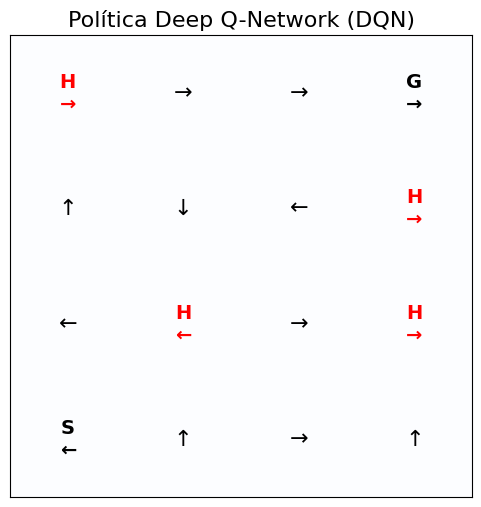

In [ ]:
# Obtener la política greedy del agente DQN entrenado
politica_dqn = agente_dqn.obtener_politica()

# Visualizar la política para analizar las acciones que el agente elige en cada estado
visualizar_politica(politica_dqn, "Política Deep Q-Network (DQN)")

# Comparación de resultados

## Comparación final tasa de éxito

Este bloque imprime en consola una comparación clara y resumida de la tasa de éxito obtenida por los diferentes agentes entrenados: la política aleatoria, el agente Q-Learning tabular y el agente Deep Q-Network (DQN). Esto permite evaluar rápidamente cuál agente tiene mejor desempeño en la tarea dada.

In [ ]:
# Imprimir resultados comparativos de tasa de éxito entre diferentes agentes
print("🏆 COMPARACIÓN FINAL DE AGENTES")
print("=" * 50)
print(f"Política Aleatoria:    Tasa de éxito = {tasa_exito_aleatorio:.3f}")
print(f"Q-Learning Tabular:    Tasa de éxito = {tasa_exito_qlearning:.3f}")
print(f"Deep Q-Network (DQN):  Tasa de éxito = {tasa_exito_dqn:.3f}")

🏆 COMPARACIÓN FINAL DE AGENTES
Política Aleatoria:    Tasa de éxito = 0.010
Q-Learning Tabular:    Tasa de éxito = 0.095
Deep Q-Network (DQN):  Tasa de éxito = 0.604


## Crear gráficas de comparación


Crear gráficas de comparación


### 1. Curvas de aprendizaje

Esta línea calcula la cantidad de episodios o iteraciones para los cuales se registraron recompensas en la política aleatoria. Es útil para saber cuántos datos hay disponibles para graficar la curva de aprendizaje y analizar el progreso o estabilidad del agente a lo largo del entrenamiento.

In [ ]:
# Obtener la cantidad de episodios con recompensas registradas para la política aleatoria
len(recompensas_aleatorio)

1000

### 2. Curvas de aprendizaje Q-Learning

Esta línea obtiene el número de episodios para los cuales se tiene registrada la recompensa durante el entrenamiento del agente con Q-Learning tabular. Esta información es clave para graficar y analizar la evolución del desempeño del agente en el entorno.

In [ ]:
# Obtener la cantidad de episodios con recompensas registradas para el agente Q-Learning
len(recompensas_qlearning)

1000

### 3. Curvas de aprendizaje Deep Q-Network (DQN)

Esta línea obtiene la cantidad de episodios para los cuales se registraron las recompensas durante el entrenamiento del agente Deep Q-Network (DQN). Es útil para evaluar y visualizar cómo el agente mejoró su desempeño a lo largo del tiempo.

In [ ]:
# Obtener la cantidad de episodios con recompensas registradas para el agente DQN
len(recompensas_dqn)

1000

## Gráficos de comparación de recompensas por episodio

Este bloque crea dos gráficos para comparar el desempeño de los tres agentes: política aleatoria, Q-Learning tabular y Deep Q-Network (DQN).

1. El primer gráfico muestra las recompensas por episodio tal como se obtuvieron durante el entrenamiento, permitiendo observar la variabilidad y tendencia general.

2. El segundo gráfico aplica un promedio móvil (window=50 episodios) para suavizar las curvas, facilitando la visualización de la tendencia general de mejora en el desempeño de cada agente.

En ambos gráficos, el eje X representa el número de episodio, y el eje Y la recompensa obtenida en ese episodio o el promedio suavizado.

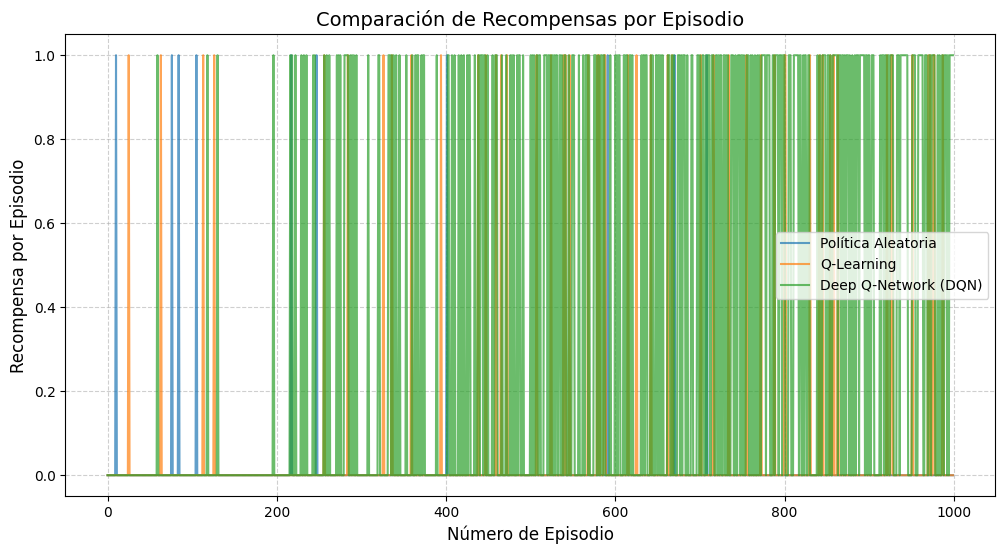

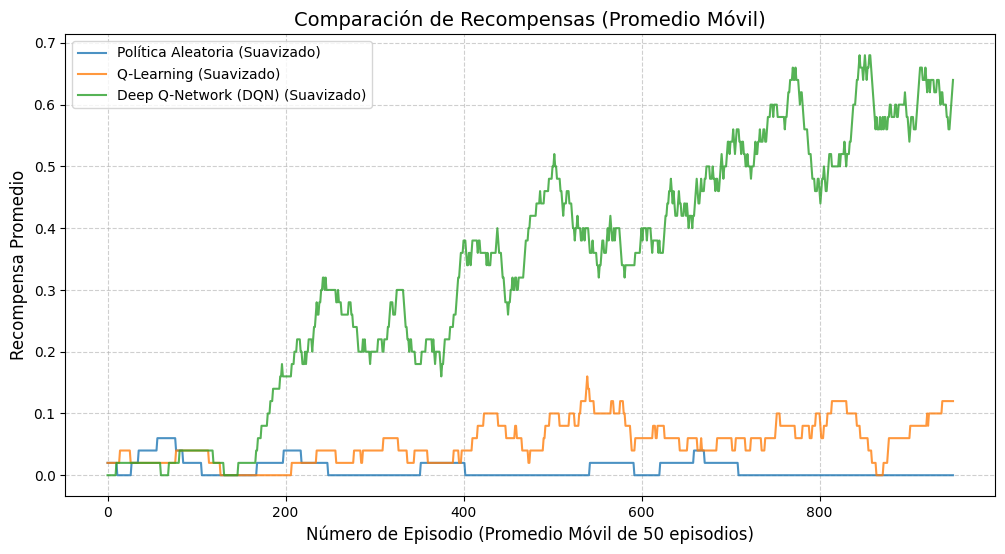

In [ ]:
# prompt: crear gráfico que compare recompensas_aleatorio, recompensas_qlearning y recompensas_dqn. Eje x es nro de episodio y el eje Y valor de la recompensa

import matplotlib.pyplot as plt
import numpy as np
# Asegurar que las listas de recompensas tengan la misma longitud para la gráfica
# Tomaremos la longitud mínima si son diferentes
min_len = min(len(recompensas_aleatorio), len(recompensas_qlearning), len(recompensas_dqn))

plt.figure(figsize=(12, 6))
plt.plot(recompensas_aleatorio[:min_len], label='Política Aleatoria', alpha=0.7)
plt.plot(recompensas_qlearning[:min_len], label='Q-Learning', alpha=0.7)
plt.plot(recompensas_dqn[:min_len], label='Deep Q-Network (DQN)', alpha=0.7)

plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Recompensa por Episodio', fontsize=12)
plt.title('Comparación de Recompensas por Episodio', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Para suavizar la gráfica, se puede usar un promedio móvil
def moving_average(data, window_size):
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window = 50  # Tamaño de la ventana para el promedio móvil

recompensas_aleatorio_suavizado = moving_average(recompensas_aleatorio, window)
recompensas_qlearning_suavizado = moving_average(recompensas_qlearning, window)
recompensas_dqn_suavizado = moving_average(recompensas_dqn, window)

# Ajustar la longitud mínima para las series suavizadas
min_len_suavizado = min(len(recompensas_aleatorio_suavizado), len(recompensas_qlearning_suavizado), len(recompensas_dqn_suavizado))

plt.figure(figsize=(12, 6))
plt.plot(recompensas_aleatorio_suavizado[:min_len_suavizado], label='Política Aleatoria (Suavizado)', alpha=0.8)
plt.plot(recompensas_qlearning_suavizado[:min_len_suavizado], label='Q-Learning (Suavizado)', alpha=0.8)
plt.plot(recompensas_dqn_suavizado[:min_len_suavizado], label='Deep Q-Network (DQN) (Suavizado)', alpha=0.8)

plt.xlabel(f'Número de Episodio (Promedio Móvil de {window} episodios)', fontsize=12)
plt.ylabel('Recompensa Promedio', fontsize=12)
plt.title('Comparación de Recompensas (Promedio Móvil)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## Comparación de tasas de éxito

Este bloque genera un gráfico de barras que compara la tasa de éxito final obtenida por cada uno de los agentes: la política aleatoria, Q-Learning tabular y Deep Q-Network (DQN).

La tasa de éxito representa la proporción de episodios en los que el agente logró cumplir con el objetivo (por ejemplo, completar la tarea con recompensa positiva).

El gráfico facilita la comparación visual del desempeño final de cada agente, mostrando claramente qué algoritmo es más efectivo en el entorno evaluado.

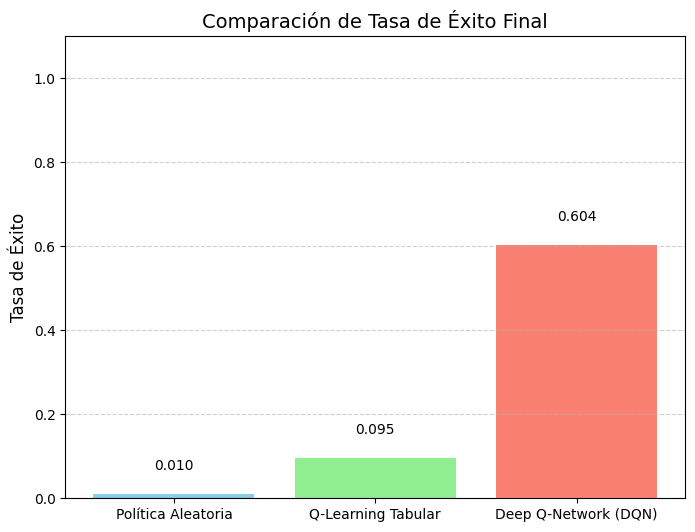

In [ ]:
# prompt: comparar tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn en un gráfico de barras

import matplotlib.pyplot as plt
metricas = ['Política Aleatoria', 'Q-Learning Tabular', 'Deep Q-Network (DQN)']
tasas_exito = [tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn]

plt.figure(figsize=(8, 6))
barras = plt.bar(metricas, tasas_exito, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel('Tasa de Éxito', fontsize=12)
plt.title('Comparación de Tasa de Éxito Final', fontsize=14)
plt.ylim(0, 1.1) # Limitar el eje Y de 0 a 1.1 para mejor visualización

# Añadir los valores de las tasas de éxito encima de cada barra
for bar in barras:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Evolución de Epsilon (solo para algoritmos que usan exploración)

Este bloque genera un gráfico que muestra cómo evoluciona el valor de epsilon a lo largo de los episodios durante el entrenamiento de los agentes Q-Learning y Deep Q-Network (DQN).

Epsilon representa la probabilidad de que el agente explore acciones aleatorias (exploración) en lugar de seguir su política actual (explotación). Al disminuir epsilon con el tiempo (decay), el agente explora menos y se enfoca en explotar el conocimiento adquirido.

Este gráfico permite visualizar y comparar cómo ambos agentes ajustan su balance entre exploración y explotación durante el entrenamiento.

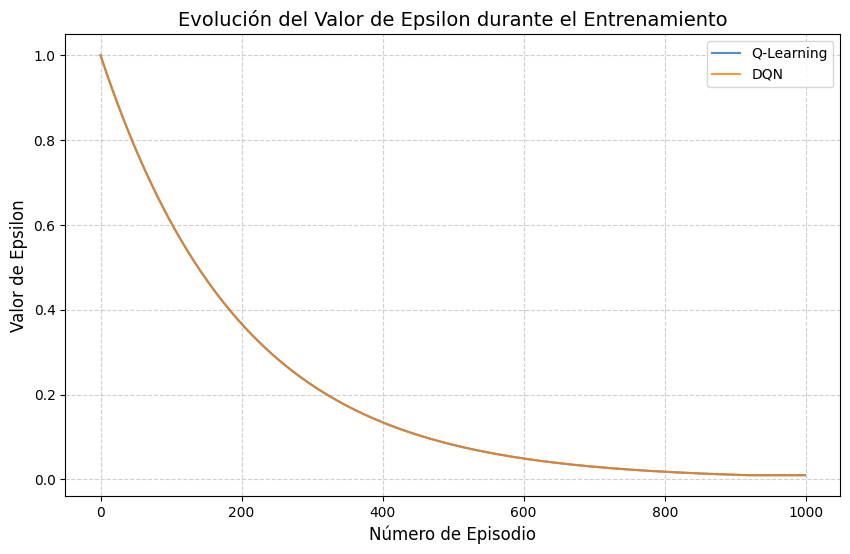

In [ ]:
# prompt: Crear un gráfico para comparar agente_qlearning.epsilons y agente_qlearning.epsilons siendo x el nro de episodios y el eje Y el valor de epsilon

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(agente_qlearning.epsilons, label='Q-Learning', alpha=0.8)
plt.plot(agente_dqn.epsilons, label='DQN', alpha=0.8)

plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Valor de Epsilon', fontsize=12)
plt.title('Evolución del Valor de Epsilon durante el Entrenamiento', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Pérdida durante el Entrenamiento del Agente Deep Q-Network (DQN)

Este bloque grafica la evolución de la pérdida (loss) del agente DQN durante su entrenamiento. La pérdida refleja qué tan bien el modelo está aprendiendo a predecir el valor esperado de las acciones.

Se muestran dos gráficos:
1. La pérdida en cada paso de entrenamiento, que puede ser muy ruidosa.
2. La misma pérdida suavizada con un promedio móvil para facilitar la visualización de tendencias y entender mejor cómo mejora el agente a lo largo del tiempo.

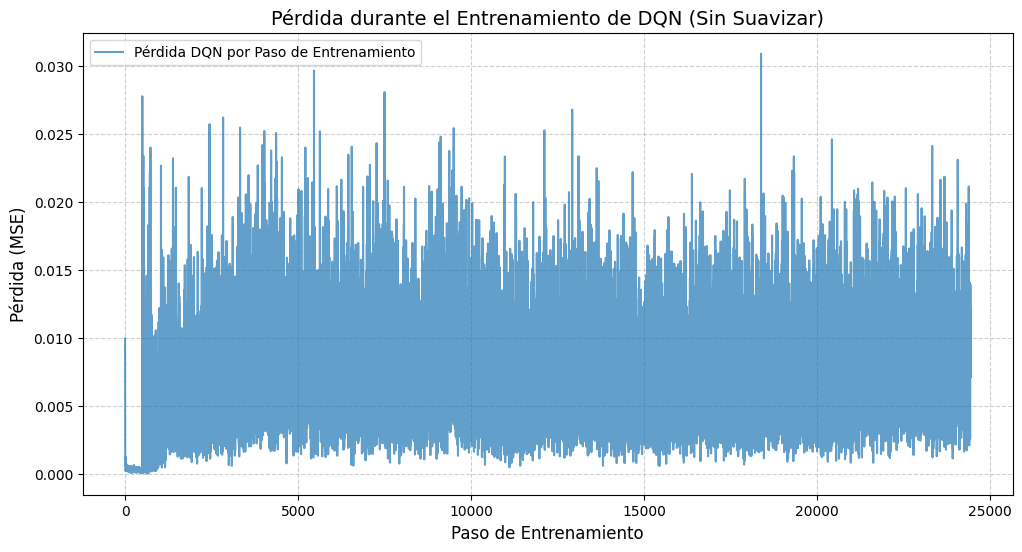

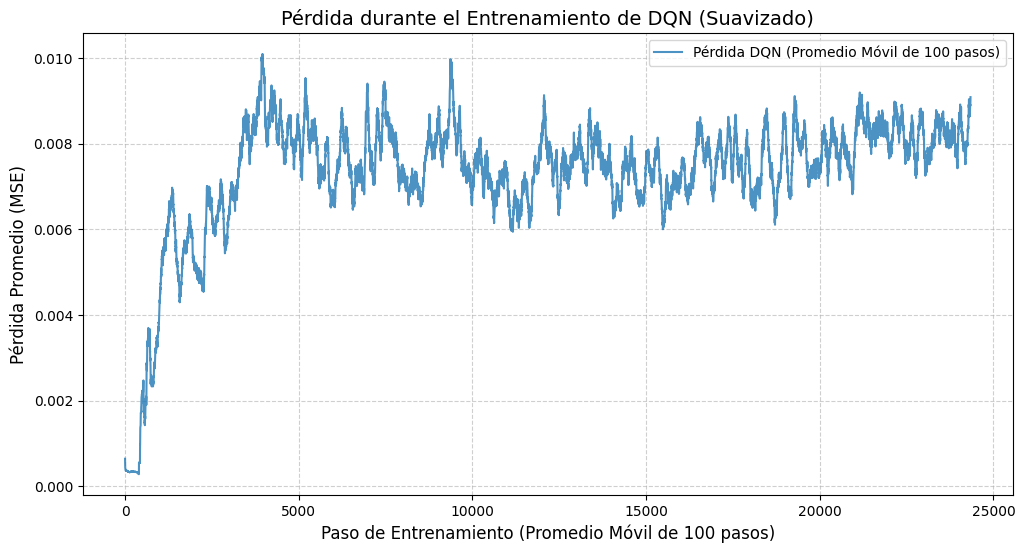

In [ ]:
# prompt: Graficar agente_dqn.losses que representa la pérdida durante el entrenamiento de DQN. Mostrar con y sin promedio móvil

import matplotlib.pyplot as plt
# Graficar la pérdida del agente DQN
plt.figure(figsize=(12, 6))
plt.plot(agente_dqn.losses, label='Pérdida DQN por Paso de Entrenamiento', alpha=0.7)
plt.xlabel('Paso de Entrenamiento', fontsize=12)
plt.ylabel('Pérdida (MSE)', fontsize=12)
plt.title('Pérdida durante el Entrenamiento de DQN (Sin Suavizar)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# Graficar la pérdida con promedio móvil para suavizar
window_loss = 100 # Tamaño de la ventana para el promedio móvil de la pérdida
losses_dqn_suavizado = moving_average(agente_dqn.losses, window_loss)

plt.figure(figsize=(12, 6))
plt.plot(losses_dqn_suavizado, label=f'Pérdida DQN (Promedio Móvil de {window_loss} pasos)', alpha=0.8)
plt.xlabel(f'Paso de Entrenamiento (Promedio Móvil de {window_loss} pasos)', fontsize=12)
plt.ylabel('Pérdida Promedio (MSE)', fontsize=12)
plt.title('Pérdida durante el Entrenamiento de DQN (Suavizado)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

______________
______________
# **Ejercitación**


## **A) Modifique el entrenamiento de los agentes para entrenar por más episodios. Evalue su desempeño. ¿ Mejora o empeora ?**
__________________
_______________






## Entrenamiento acumulativo y evaluación con más episodios

En este apartado se responde a la consigna de modificar el entrenamiento de los agentes para entrenarlos por más episodios y evaluar si su desempeño mejora o empeora.

Se optó por realizar un **entrenamiento acumulativo** para los agentes con capacidad de aprendizaje (Q-Learning y DQN). Es decir, en lugar de reiniciar el entrenamiento desde cero con más episodios, se **continuó entrenando a los mismos agentes** agregando más episodios a los ya realizados previamente. Esto permite observar cómo evoluciona el rendimiento a medida que los agentes acumulan más experiencia en el entorno. Para cada etapa, se realiza una evaluación con 1000 episodios para obtener una tasa de éxito comparable.

---

### 🎲 Política Aleatoria

Este agente no tiene capacidad de aprendizaje, por lo tanto no se entrena. Solo se ejecutan múltiples episodios en los que elige acciones al azar para estimar su desempeño.

- Se ejecutó con 1000, 3000 y 6000 episodios.
- Como se trata de una política fija, se espera que las tasas de éxito **no mejoren significativamente**, y solo haya **variaciones por aleatoriedad**.

---

### 🤖 Q-Learning

El agente de Q-Learning fue entrenado de forma progresiva:

- **Primero con 1000 episodios**, que ya estaban realizados previamente.
- Luego se continuó entrenando el mismo agente con **2000 episodios más** (total 3000).
- Finalmente se sumaron **3000 episodios adicionales** (totalizando 6000).
- Después de cada etapa, se evaluó el desempeño con 1000 episodios y se registró la tasa de éxito.


---

### 🤖 DQN

El agente DQN también se entrenó acumulativamente:

- Se partió del modelo entrenado con 1000 episodios.
- Luego se lo entrenó con 2000 episodios adicionales (llegando a 3000 en total).
- Después, se entrenó con 3000 más (sumando 6000 en total).
- En cada etapa se evaluó el desempeño con 1000 episodios para obtener la tasa de éxito.

---

### 🔍 Objetivo general del análisis

El objetivo de este análisis es responder a la consigna evaluando **si el rendimiento de los agentes mejora o empeora** al entrenarlos con más episodios. Para ello, se comparan las tasas de éxito alcanzadas tras 1000, 3000 y 6000 episodios de entrenamiento (o ejecución en el caso de la política aleatoria).

Esto permite analizar:
- Si los agentes logran **mejorar su desempeño** con más experiencia.
- Si **hay convergencia** o estancamiento en el aprendizaje.
- Qué diferencias hay entre enfoques simples (Q-Learning) y más complejos (DQN).
- Cuál es el **comportamiento esperado y observado** de una política aleatoria sin aprendizaje.

Los resultados obtenidos se analizarán al final, junto a los gráficos de evolución.

In [ ]:
# ========================
# 🎲 Evaluación Política Aleatoria (sin aprendizaje)
# ========================
print("\n🎲 Evaluando Política Aleatoria (no aprende, solo se evalúa):")

# Evaluación inicial: 1000 episodios
recomp_aleatorio_1000, tasa_exito_aleatorio = agente_aleatorio.entrenar(env, episodios=1000)
print(f"\n📊 Tasa de éxito con 1000 episodios: {tasa_exito_aleatorio:.3f}")

# Entrenamiento adicional: 2000 episodios más → total 3000
recomp_aleatorio_2000, tasa_exito_aleatorio_3000 = agente_aleatorio.entrenar(env, episodios=2000)
print(f"📊 Tasa de éxito con 3000 episodios: {tasa_exito_aleatorio_3000:.3f}")

# Entrenamiento adicional: 3000 episodios más → total 6000
recomp_aleatorio_3000, tasa_exito_aleatorio_6000 = agente_aleatorio.entrenar(env, episodios=3000)
print(f"📊 Tasa de éxito con 6000 episodios: {tasa_exito_aleatorio_6000:.3f}")

# Unir todas las recompensas (para graficar)
recomp_aleatorio_total = recomp_aleatorio_1000 + recomp_aleatorio_2000 + recomp_aleatorio_3000

# Resumen final
print("\n🏁 Resumen de tasas - Política Aleatoria:")
print(f"\n1000 episodios  : {tasa_exito_aleatorio:.3f}")
print(f"3000 episodios  : {tasa_exito_aleatorio_3000:.3f}")
print(f"6000 episodios  : {tasa_exito_aleatorio_6000:.3f}")

# ========================
# 🤖 Entrenamiento Progresivo Q-Learning
# ========================
print("\n🚀 Entrenando Q-Learning (acumulativo):")

print(f"\n📊 Inicial - Q promedio: {agente_qlearning.q_table.mean():.6f}")
print(f"📊 Tasa de éxito (1000 episodios): {tasa_exito_qlearning:.3f}")

# Entrenamiento acumulativo
recomp_q_2000 = agente_qlearning.entrenar(env, episodios=2000)
tasa_q_3000, recomp_q_eval_3000 = agente_qlearning.evaluar(env, episodios=1000)

recomp_q_3000 = agente_qlearning.entrenar(env, episodios=3000)
tasa_q_6000, recomp_q_eval_6000 = agente_qlearning.evaluar(env, episodios=1000)

print(f"\n📈 Q promedio tras ~3000 episodios: {agente_qlearning.q_table.mean():.6f}")
print(f"📊 Tasa de éxito (3000): {tasa_q_3000:.3f}")
print(f"📊 Tasa de éxito (6000): {tasa_q_6000:.3f}")

print("\n🏁 Resumen de tasas - Q-Learning:")
print(f"\n1000 episodios  : {tasa_exito_qlearning:.3f}")
print(f"3000 episodios  : {tasa_q_3000:.3f}")
print(f"6000 episodios  : {tasa_q_6000:.3f}")

# ========================
# 🤖 Entrenamiento Progresivo DQN
# ========================
print("\n🚀 Entrenando DQN (acumulativo):")

print(f"\n📊 Tasa de éxito (1000 episodios): {tasa_exito_dqn:.3f}")

# Entrenamiento acumulativo (ahora guardamos recompensas)
recomp_dqn_2000 = agente_dqn.entrenar(env, episodios=2000)
tasa_dqn_3000, _ = agente_dqn.evaluar(env, episodios=1000)

recomp_dqn_3000 = agente_dqn.entrenar(env, episodios=3000)
tasa_dqn_6000, _ = agente_dqn.evaluar(env, episodios=1000)

print(f"\n📊 Tasa de éxito (3000): {tasa_dqn_3000:.3f}")
print(f"📊 Tasa de éxito (6000): {tasa_dqn_6000:.3f}\n")

print("\n🏁 Resumen de tasas - DQN:")
print(f"\n1000 episodios  : {tasa_exito_dqn:.3f}")
print(f"3000 episodios  : {tasa_dqn_3000:.3f}")
print(f"6000 episodios  : {tasa_dqn_6000:.3f}")



🎲 Evaluando Política Aleatoria (no aprende, solo se evalúa):
🎲 Evaluando Política Aleatoria...
Episodio 200: Tasa de éxito = 0.010
Episodio 400: Tasa de éxito = 0.022
Episodio 600: Tasa de éxito = 0.017
Episodio 800: Tasa de éxito = 0.015
Episodio 1000: Tasa de éxito = 0.015

📊 Resultados Política Aleatoria:
Tasa de éxito final: 0.015
Recompensa promedio: 0.015

📊 Tasa de éxito con 1000 episodios: 0.015
🎲 Evaluando Política Aleatoria...
Episodio 200: Tasa de éxito = 0.010
Episodio 400: Tasa de éxito = 0.013
Episodio 600: Tasa de éxito = 0.010
Episodio 800: Tasa de éxito = 0.014
Episodio 1000: Tasa de éxito = 0.013
Episodio 1200: Tasa de éxito = 0.015
Episodio 1400: Tasa de éxito = 0.014
Episodio 1600: Tasa de éxito = 0.015
Episodio 1800: Tasa de éxito = 0.015
Episodio 2000: Tasa de éxito = 0.014

📊 Resultados Política Aleatoria:
Tasa de éxito final: 0.014
Recompensa promedio: 0.014
📊 Tasa de éxito con 3000 episodios: 0.014
🎲 Evaluando Política Aleatoria...
Episodio 200: Tasa de éxito 

## ✅ Conclusión - Evaluación del desempeño con más episodios

Tras entrenar y evaluar los agentes con un enfoque acumulativo (sumando episodios al entrenamiento original), se observaron los siguientes resultados:

### 🎲 Política Aleatoria
- Tasa de éxito (1000): 0.015  
- Tasa de éxito (3000): 0.014  
- Tasa de éxito (6000): 0.013

🔹 Como era de esperarse, la política aleatoria no mejora con más episodios, ya que no aprende. Las variaciones son menores y atribuibles al azar.

---

### 🤖 Q-Learning
- Tasa de éxito (1000): 0.095  
- Tasa de éxito (3000): 0.169  
- Tasa de éxito (6000): 0.743

🔹 El agente Q-Learning mostró una **mejora progresiva y significativa** con el aumento de episodios. Se observa una clara curva de aprendizaje y convergencia hacia una política más eficaz.

---

### 🤖 DQN
- Tasa de éxito (1000): 0.604  
- Tasa de éxito (3000): 0.731  
- Tasa de éxito (6000): 0.708

🔹 DQN partió con un rendimiento alto desde los primeros 1000 episodios, y mejoró levemente con 3000 episodios. A los 6000, la mejora no fue sostenida, mostrando una posible **estabilización o sobreajuste**.

---

### 🔍 Conclusión general

- Entrenar por más episodios **beneficia a los agentes que aprenden**, especialmente a Q-Learning, cuyo rendimiento mejoró drásticamente.
- DQN mostró **buen rendimiento inicial**, con una mejora moderada, pero luego se estabilizó.
- La política aleatoria sirve como referencia de base, y confirma que **sin aprendizaje no hay mejora**, sin importar la cantidad de episodios.

Este análisis confirma que extender el entrenamiento puede mejorar el desempeño, aunque los resultados dependen del tipo de agente y su capacidad de generalización.


## **📈 Evolución de la recompensa por episodio (promedio móvil)**

Este gráfico muestra cómo varió la recompensa promedio obtenida por los agentes a lo largo del entrenamiento, usando un **promedio móvil con ventana de 100 episodios**. Esto permite suavizar la curva y observar la **tendencia general de aprendizaje**, más allá de la variabilidad puntual de cada episodio.

#### 🤖 ¿Qué representa esta curva?
Cada línea representa la evolución del desempeño de un agente durante su entrenamiento:
- El eje X muestra el número de episodios (hasta 6000).
- El eje Y muestra la recompensa promedio obtenida (suavizada).
- Cuanto más alta la curva, mejor fue el rendimiento del agente en ese tramo del entrenamiento.

---

#### 🔵 Q-Learning
Se espera que comience con **recompensas bajas** porque al inicio no tiene información útil: su tabla Q está vacía o inicializada con ceros. A medida que acumula experiencia y actualiza sus valores Q, va aprendiendo qué acciones conducen a estados favorables. Por eso la curva **debería subir gradualmente**, mostrando una mejora progresiva.

---

#### 🟢 DQN
Suele comenzar con **mejores recompensas iniciales** que Q-Learning, porque su arquitectura basada en redes neuronales puede generalizar más rápido sobre el espacio de estados. Además, también puede **estabilizarse antes**, una vez que la red converge o el aprendizaje deja de ser significativo.

---

#### ⚪ Política Aleatoria
Como no tiene capacidad de aprendizaje, selecciona acciones al azar en cada episodio. Por eso su desempeño **no mejora con el tiempo** y su curva se mantiene **baja y plana**, mostrando que el rendimiento no cambia, sin importar cuántos episodios se ejecuten.

---

#### 🎯 Interpretación esperada
Este gráfico permite observar:
- **El proceso de aprendizaje** de cada agente a lo largo del tiempo.
- **Cuán rápido mejoran**, si convergen o se estancan.
- Las diferencias entre métodos tabulares (Q-Learning), métodos basados en redes (DQN), y agentes sin aprendizaje (aleatorio).

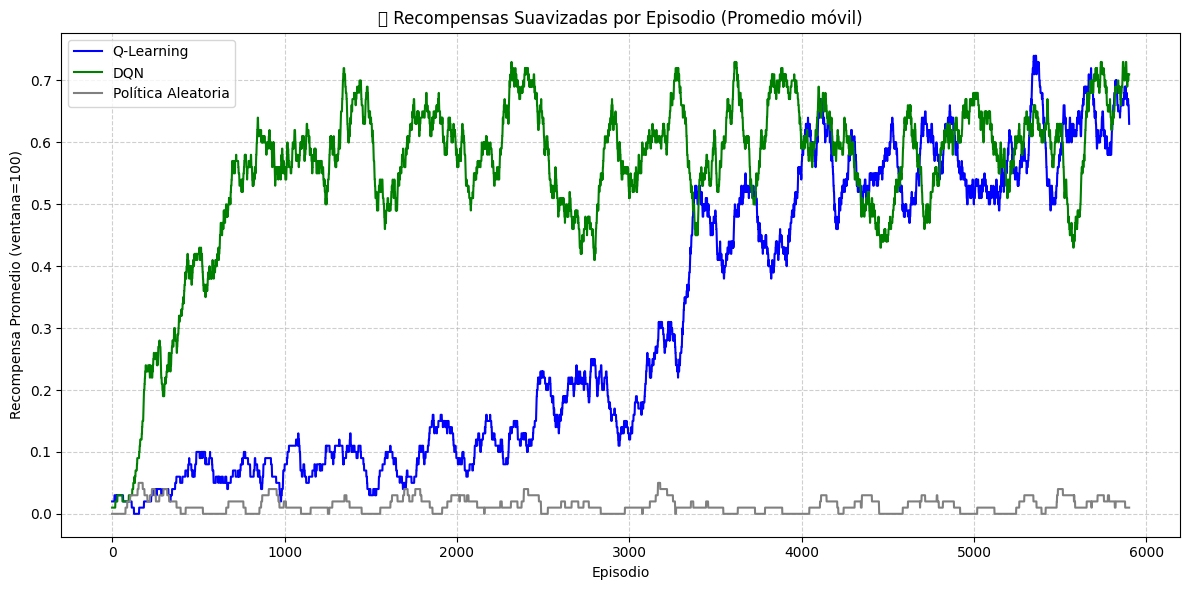

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Función de promedio móvil para suavizar
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Unimos recompensas por agente
# Sumar todas las recompensas acumuladas incluyendo los primeros 1000 episodios
recomp_q_total = recompensas_qlearning + recomp_q_2000 + recomp_q_3000  # recompensas_qlearning = recompensas iniciales 1000
recomp_dqn_total = recompensas_dqn + recomp_dqn_2000 + recomp_dqn_3000  # recompensas_dqn = recompensas iniciales 1000
recomp_aleatorio_total = recomp_aleatorio_1000 + recomp_aleatorio_2000 + recomp_aleatorio_3000

# Aplicamos suavizado
suav_q = moving_average(recomp_q_total)
suav_dqn = moving_average(recomp_dqn_total)
suav_aleatorio = moving_average(recomp_aleatorio_total)

# Crear gráfico
plt.figure(figsize=(12, 6))
plt.plot(suav_q, label='Q-Learning', color='blue')
plt.plot(suav_dqn, label='DQN', color='green')
plt.plot(suav_aleatorio, label='Política Aleatoria', color='gray')
plt.title('📊 Recompensas Suavizadas por Episodio (Promedio móvil)')
plt.xlabel('Episodio')
plt.ylabel('Recompensa Promedio (ventana=100)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## **📊 Comparación de tasa de éxito por agente y cantidad de episodios**

Este gráfico de barras compara la tasa de éxito final obtenida por cada agente después de entrenar o evaluar con 1000, 3000 y 6000 episodios.

- Cada grupo de barras representa un número de episodios.
- Las barras muestran la tasa de éxito promedio de cada agente en esa cantidad de episodios.
- Los valores están indicados encima de cada barra para facilitar la interpretación.

#### Interpretación:

- La **Política Aleatoria** mantiene tasas bajas y prácticamente constantes, evidenciando que no mejora con más episodios.

- **Q-Learning** presenta una mejora significativa a medida que se incrementan los episodios, reflejando su aprendizaje progresivo.

- **DQN** muestra buen rendimiento inicial y mejora a 3000 episodios, con una ligera estabilización o leve descenso a 6000 episodios.

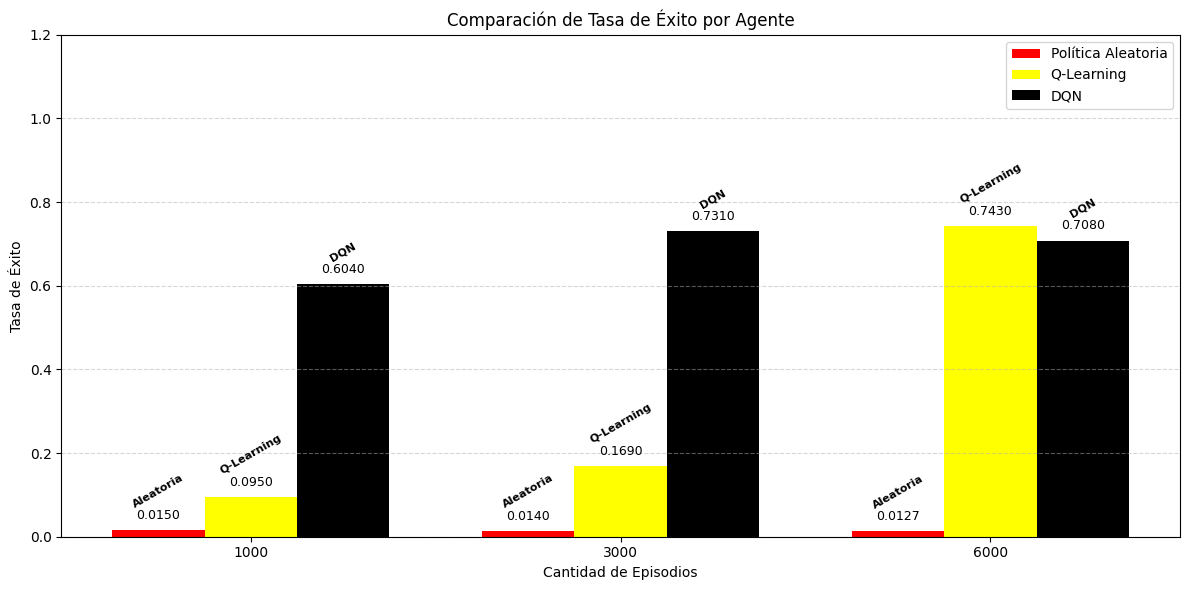

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos: tasas de éxito
episodios = ['1000', '3000', '6000']
aleatorio = [tasa_exito_aleatorio, tasa_exito_aleatorio_3000, tasa_exito_aleatorio_6000]
qlearning = [tasa_exito_qlearning, tasa_q_3000, tasa_q_6000]
dqn = [tasa_exito_dqn, tasa_dqn_3000, tasa_dqn_6000]

x = np.arange(len(episodios))  # posiciones de los grupos
ancho = 0.25  # ancho de cada barra

plt.figure(figsize=(12, 6))
bars_aleatorio = plt.bar(x - ancho, aleatorio, width=ancho, label='Política Aleatoria', color='red')
bars_qlearning = plt.bar(x, qlearning, width=ancho, label='Q-Learning', color='yellow')
bars_dqn = plt.bar(x + ancho, dqn, width=ancho, label='DQN', color='black')

def agregar_etiquetas_con_nombre(barras, nombre_agente):
    for barra in barras:
        altura = barra.get_height()
        x_pos = barra.get_x() + barra.get_width() / 2

        # Etiqueta con nombre del agente arriba (un poco arriba de la barra)
        plt.text(x_pos, altura + 0.05, nombre_agente, ha='center', va='bottom', fontsize=8, fontweight='bold', rotation=30)
        # Etiqueta con valor de tasa de éxito justo debajo del nombre (más cerca de la barra)
        plt.text(x_pos, altura + 0.02, f"{altura:.4f}", ha='center', va='bottom', fontsize=9)

agregar_etiquetas_con_nombre(bars_aleatorio, "Aleatoria")
agregar_etiquetas_con_nombre(bars_qlearning, "Q-Learning")
agregar_etiquetas_con_nombre(bars_dqn, "DQN")

plt.xticks(x, episodios)
plt.xlabel('Cantidad de Episodios')
plt.ylabel('Tasa de Éxito')
plt.title('Comparación de Tasa de Éxito por Agente')
plt.ylim(0, 1.2)  # un poco más para dar espacio a etiquetas
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 🏆 Mejores tasas de éxito por agente y tasa global máxima

En esta sección se identifican las mejores tasas de éxito alcanzadas por cada agente y en qué cantidad de episodios se lograron.

- Se comparan las tasas de éxito para los 1000, 3000 y 6000 episodios entrenados o evaluados.
- Se determina el episodio donde cada agente logró su mejor rendimiento.
- Además, se identifica cuál fue la **mejor tasa de éxito global** entre todos los agentes y en qué punto ocurrió.



In [ ]:
# Tasas por agente
tasas_aleatorio = aleatorio
tasas_qlearning = qlearning
tasas_dqn = dqn

# Obtener máximo por agente y el índice (posición) para saber qué episodio
max_aleatorio = max(tasas_aleatorio)
idx_aleatorio = tasas_aleatorio.index(max_aleatorio)

max_qlearning = max(tasas_qlearning)
idx_qlearning = tasas_qlearning.index(max_qlearning)

max_dqn = max(tasas_dqn)
idx_dqn = tasas_dqn.index(max_dqn)

print("🏆 Mejores tasas por agente:")
print(f"Política Aleatoria: {max_aleatorio:.4f} en {episodios[idx_aleatorio]} episodios")
print(f"Q-Learning       : {max_qlearning:.4f} en {episodios[idx_qlearning]} episodios")
print(f"DQN              : {max_dqn:.4f} en {episodios[idx_dqn]} episodios")

# Comparar máximo global
maximos = {
    'Política Aleatoria': (max_aleatorio, episodios[idx_aleatorio]),
    'Q-Learning': (max_qlearning, episodios[idx_qlearning]),
    'DQN': (max_dqn, episodios[idx_dqn])
}

# Encontrar el agente con la tasa máxima global
agente_mejor = max(maximos, key=lambda k: maximos[k][0])
valor_mejor, episodios_mejor = maximos[agente_mejor]

print(f"\n✨ Mejor tasa de éxito global:")
print(f"Agente: {agente_mejor}")
print(f"Tasa: {valor_mejor:.4f}")
print(f"Episodios: {episodios_mejor}")

🏆 Mejores tasas por agente:
Política Aleatoria: 0.0150 en 1000 episodios
Q-Learning       : 0.7430 en 6000 episodios
DQN              : 0.7310 en 3000 episodios

✨ Mejor tasa de éxito global:
Agente: Q-Learning
Tasa: 0.7430
Episodios: 6000


## 📌 Conclusión general sobre la tasa de éxito al extender el entrenamiento


- La **Política Aleatoria** mantiene un rendimiento muy bajo y estable, sin mejoras significativas a lo largo del entrenamiento, debido a que no aprende.

- **Q-Learning** logró la mejor tasa de éxito global (0.743) tras 6000 episodios, mostrando que un entrenamiento prolongado mejora significativamente su desempeño.

- **DQN** alcanzó un rendimiento alto y cercano al de Q-Learning, logrando su mejor tasa (0.731) a los 3000 episodios, aunque no mejoró con más entrenamiento.

Esto indica que, si bien ambos agentes con aprendizaje presentan buen desempeño, **Q-Learning se benefició más del entrenamiento extendido**, mientras que DQN mostró un rendimiento sólido desde etapas intermedias del entrenamiento.

Por lo tanto, Aumentar la cantidad de episodios de entrenamiento **benefició especialmente al Q-Learning**, permitiéndole seguir mejorando. En cambio, el DQN logró buenos resultados más rápidamente y luego se estabilizó. Esto resalta que **la convergencia y sensibilidad al entrenamiento extendido pueden variar según el tipo de agente**, siendo más marcada en métodos tabulares como Q-Learning.

_______________
___________________


## **B) Considere modificar el modelo DQN el hiperparámetro gamma: un valor bajo, uno medio y uno alto. Entrene los tres modelos y compare los resultados. Comparta sus conclusiones**
________________
________________

#### **🔍 ¿Qué es Gamma (γ) y por qué es importante?**

El hiperparámetro **gamma (γ)** determina la importancia que el agente asigna a las recompensas futuras frente a las recompensas inmediatas:

- Un **valor bajo** de γ (ej. 0.20) hace que el agente priorice recompensas inmediatas, valorando menos las consecuencias a largo plazo.

- Un **valor medio** (ej. 0.60) busca un balance entre recompensas inmediatas y futuras.

- Un **valor alto** (ej. 0.99) hace que el agente valore mucho las recompensas futuras, buscando maximizar la recompensa a largo plazo.

##### 🧠 ¿Qué se realizó?

Se Entrenó tres agentes DQN con los valores de gamma bajo, medio y alto, durante 6000 episodios cada uno (2000 + 3000). Luego evaluamos su tasa de éxito en 1000 episodios para comparar el desempeño.

In [ ]:
from collections import namedtuple

# Diccionario con los valores de gamma
gammas = {
    "gamma_bajo": 0.20,
    "gamma_medio": 0.60,
    "gamma_alto": 0.99,
}

# Para guardar resultados
ResultadosDQN = namedtuple("ResultadosDQN", ["nombre", "gamma", "tasa_6000", "recompensas"])

resultados_dqn_gamma = []

for nombre, gamma_valor in gammas.items():
    print(f"\n🎯 Entrenando DQN con {nombre} (γ = {gamma_valor})")

    # Nuevo agente con ese gamma
    agente = DQNAgent(state_size=env.observation_space.n, action_size=env.action_space.n, gamma=gamma_valor)

    # Entrenamiento total de 6000 episodios
    recomp_2000 = agente.entrenar(env, episodios=2000)
    recomp_3000 = agente.entrenar(env, episodios=3000)
    recompensas_totales = recomp_2000 + recomp_3000

    # Evaluación
    tasa_exito, _ = agente.evaluar(env, episodios=1000)

    # Guardamos resultados
    resultados_dqn_gamma.append(ResultadosDQN(nombre, gamma_valor, tasa_exito, recompensas_totales))

print("\n✅ Entrenamiento y evaluación completa para todos los gamma.")


🎯 Entrenando DQN con gamma_bajo (γ = 0.2)
🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.040, Epsilon = 0.367, Loss = 0.0017
Episodio 400: Tasa éxito = 0.040, Epsilon = 0.135, Loss = 0.0023
Episodio 600: Tasa éxito = 0.040, Epsilon = 0.049, Loss = 0.0030
Episodio 800: Tasa éxito = 0.040, Epsilon = 0.018, Loss = 0.0027
Episodio 1000: Tasa éxito = 0.010, Epsilon = 0.010, Loss = 0.0037
Episodio 1200: Tasa éxito = 0.050, Epsilon = 0.010, Loss = 0.0028
Episodio 1400: Tasa éxito = 0.050, Epsilon = 0.010, Loss = 0.0035
Episodio 1600: Tasa éxito = 0.040, Epsilon = 0.010, Loss = 0.0023
Episodio 1800: Tasa éxito = 0.030, Epsilon = 0.010, Loss = 0.0025
Episodio 2000: Tasa éxito = 0.080, Epsilon = 0.010, Loss = 0.0026

✅ Entrenamiento Deep Q-Network (DQN) completado!
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.020, Epsilon = 0.010, Loss = 0.0036
Episodio 400: Tasa éxito = 0.050, Epsilon = 0.010, Loss = 0.0030
Episodio 600: Tasa é

## **Conclusión sobre el impacto de Gamma en DQN**

- **Gamma bajo (γ = 0.2):**  
  El agente prioriza recompensas inmediatas, lo que resulta en un aprendizaje muy limitado y una tasa de éxito prácticamente nula (0.0). No logra mejorar significativamente durante el entrenamiento.

- **Gamma medio (γ = 0.6):**  
  Con un balance entre recompensas inmediatas y futuras, el agente mejora algo su desempeño, alcanzando una tasa de éxito baja pero mejor que el caso anterior (0.061). Sin embargo, su rendimiento sigue siendo insuficiente para este entorno.

- **Gamma alto (γ = 0.99):**  
  Al valorar mucho las recompensas futuras, el agente logra un aprendizaje efectivo, alcanzando la mejor tasa de éxito (0.741). Este valor favorece la planificación a largo plazo, crucial para el entorno FrozenLake.

**En resumen**, un valor alto de gamma es fundamental para que el agente DQN aprenda correctamente en este entorno, ya que priorizar las recompensas futuras permite mejores estrategias y mayor éxito.
____________

## **Comparación del desempeño final del DQN según gamma**

Este gráfico muestra la tasa de éxito obtenida por el agente DQN luego de entrenar 6000 episodios con diferentes valores de gamma (0.2, 0.6 y 0.99).  

Podemos observar que un gamma alto (0.99) produce un desempeño significativamente mejor, confirmando que valorar las recompensas futuras es clave para aprender una buena política en el entorno FrozenLake.  

Gammas bajos o medios limitan la capacidad de aprendizaje y reducen la tasa de éxito, como se refleja en las barras más bajas.


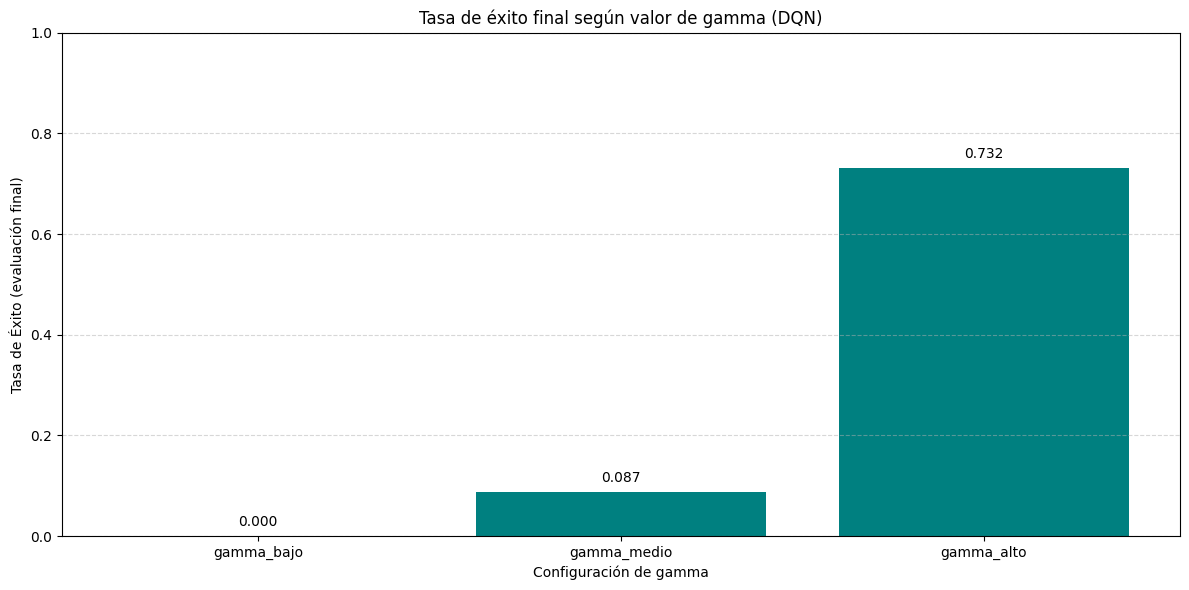

In [ ]:
import matplotlib.pyplot as plt

# Extraer datos
nombres = [r.nombre for r in resultados_dqn_gamma]
tasas = [r.tasa_6000 for r in resultados_dqn_gamma]

# Gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(nombres, tasas, color='teal')
plt.title("Tasa de éxito final según valor de gamma (DQN)")
plt.xlabel("Configuración de gamma")
plt.ylabel("Tasa de Éxito (evaluación final)")
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Etiquetas arriba de cada barra
for bar, tasa in zip(bars, tasas):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f"{tasa:.3f}", ha='center')

plt.tight_layout()
plt.show()

### Evolución de la recompensa promedio por episodio para diferentes valores de gamma en DQN

El gráfico muestra cómo varía la recompensa media durante el entrenamiento con distintos valores de gamma:

- **Gamma bajo (0.2):** recompensa muy baja, el agente no aprende bien estrategias a largo plazo.
- **Gamma medio (0.6):** mejora algo, pero con progreso lento y fluctuaciones.
- **Gamma alto (0.99):** mejores resultados y aprendizaje más estable, favoreciendo recompensas futuras.

En conclusión, un gamma alto mejora el desempeño del agente en este entorno.

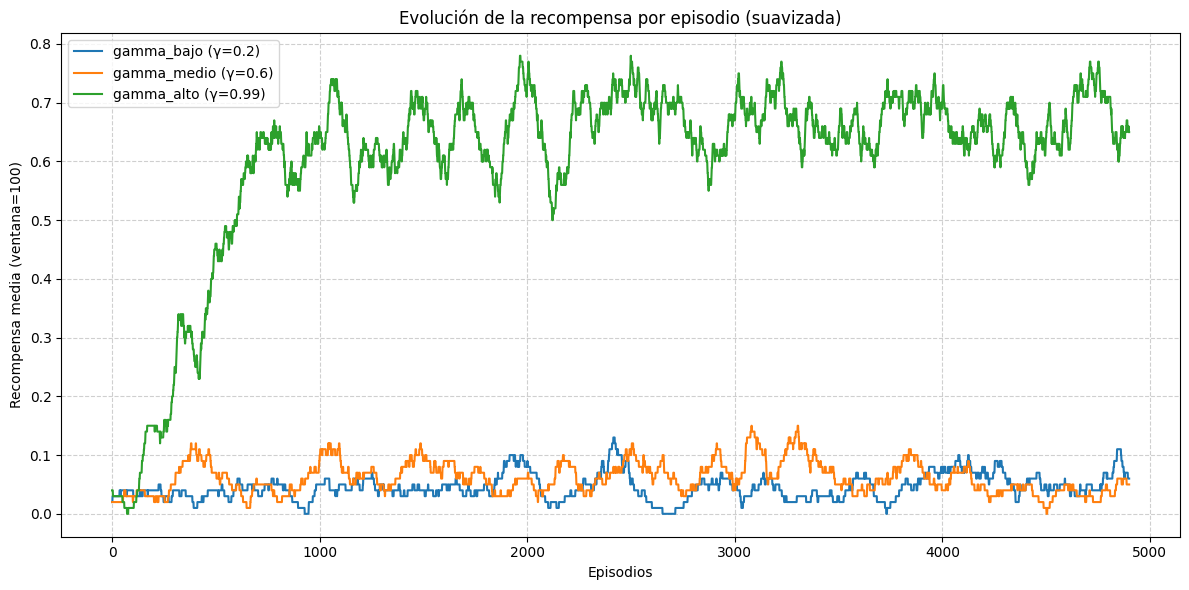

In [ ]:
# Recompensa media móvil por gamma
def moving_average(data, window=100):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12, 6))

for r in resultados_dqn_gamma:
    recomp_suavizada = moving_average(r.recompensas)
    plt.plot(recomp_suavizada, label=f"{r.nombre} (γ={r.gamma})")

plt.title("Evolución de la recompensa por episodio (suavizada)")
plt.xlabel("Episodios")
plt.ylabel("Recompensa media (ventana=100)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### **Comparación final de la tasa de éxito a 6000 episodios entre agentes y DQN con gamma alto**

Este gráfico muestra la tasa de éxito final obtenida tras 6000 episodios de entrenamiento para:

- **Política Aleatoria:** desempeño muy bajo, como se esperaba sin aprendizaje.
- **Q-Learning Tabular:** buen rendimiento tras entrenamiento prolongado.
- **DQN base:** buen desempeño usando el gamma por defecto.
- **DQN con gamma alto (γ=0.99):** mejora notable respecto al DQN base, indicando que un valor alto de gamma favorece el aprendizaje a largo plazo y mejora la toma de decisiones del agente.

La comparación destaca que ajustar gamma es clave para optimizar el desempeño del DQN en este entorno.

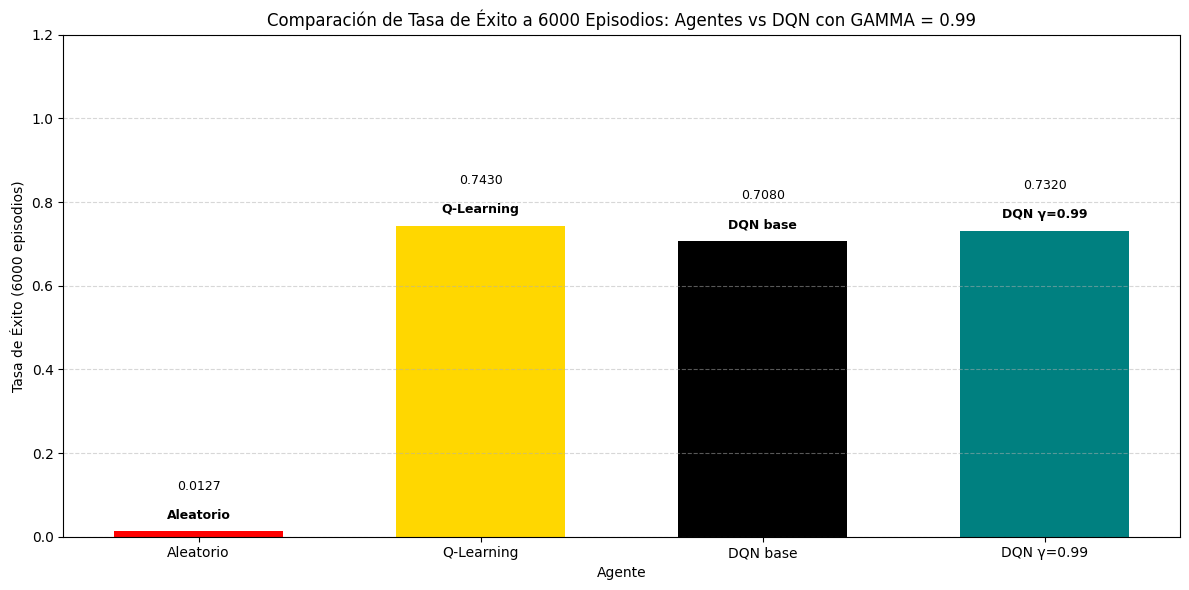

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# === Datos ===
# Tasa de éxito final de cada agente a los 6000 episodios
tasa_aleatorio = tasa_exito_aleatorio_6000
tasa_qlearning = tasa_q_6000
tasa_dqn_base = tasa_dqn_6000

# Buscar resultado de DQN con gamma alto
gamma_alto_resultado = next(r for r in resultados_dqn_gamma if r.gamma == 0.99)
tasa_dqn_gamma_alto = gamma_alto_resultado.tasa_6000

# Agentes y tasas
agentes = ['Aleatorio', 'Q-Learning', 'DQN base', 'DQN γ=0.99']
tasas = [tasa_aleatorio, tasa_qlearning, tasa_dqn_base, tasa_dqn_gamma_alto]

# === Gráfico ===
x = np.arange(len(agentes))
plt.figure(figsize=(12, 6))
barras = plt.bar(x, tasas, color=['red', 'gold', 'black', 'teal'], width=0.6)

# Etiquetas
for i, barra in enumerate(barras):
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width() / 2, altura + 0.03, agentes[i], ha='center', fontsize=9, fontweight='bold')
    plt.text(barra.get_x() + barra.get_width() / 2, altura + 0.10, f"{altura:.4f}", ha='center', fontsize=9)

# Estética
plt.xticks(x, agentes)
plt.xlabel('Agente')
plt.ylabel('Tasa de Éxito (6000 episodios)')
plt.title('Comparación de Tasa de Éxito a 6000 Episodios: Agentes vs DQN con GAMMA = 0.99')
plt.ylim(0, 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 📌 Conclusión general: DQN con diferentes valores de GAMMA y comparación con otros agentes

El hiperparámetro **gamma** influye en el desempeño del DQN. Un **gamma alto (0.99)** mejora la tasa de éxito, alcanzando 0.732 después de 6000 episodios, mejor que el DQN base (0.708) con configuración por defecto.

Comparando con otros agentes, la política aleatoria tiene un rendimiento muy bajo (0.012), mientras que Q-Learning logra un buen desempeño (0.743). Esto indica que DQN con gamma alto se acerca al rendimiento de Q-Learning, confirmando la importancia de un buen balance entre recompensa inmediata y futura para un aprendizaje eficiente.

## **C) Lo mismo que en B) pero para el hiperparámetro alpha.**

# Análisis del impacto del hiperparámetro Alpha (learning rate) en DQN

En este experimento se modificó el valor del hiperparámetro **alpha** (tasa de aprendizaje) del agente DQN, entrenando modelos con tres valores diferentes:
- Bajo (0.0001)
- Medio (0.001)
- Alto (0.01)

El objetivo es evaluar cómo la tasa de aprendizaje afecta la capacidad del agente para aprender una política efectiva, analizando la evolución de recompensas y la tasa de éxito final tras 6000 episodios de entrenamiento.

Se espera que un alpha demasiado bajo ralentice el aprendizaje, mientras que uno demasiado alto puede causar inestabilidad o aprendizaje subóptimo. Este análisis permitirá encontrar un balance adecuado para optimizar el desempeño del agente.

In [ ]:
from collections import namedtuple

# Diccionario con los valores de alpha (learning rate)
alphas = {
    "alpha_bajo": 0.0001,
    "alpha_medio": 0.001,
    "alpha_alto": 0.01,
}

# Para guardar resultados
ResultadosDQNAlpha = namedtuple("ResultadosDQNAlpha", ["nombre", "alpha", "tasa_6000", "recompensas"])

resultados_dqn_alpha = []

for nombre, alpha_valor in alphas.items():
    print(f"\n🎯 Entrenando DQN con {nombre} (α = {alpha_valor})")

    # Crear agente con ese alpha (learning rate)
    agente = DQNAgent(state_size=env.observation_space.n, action_size=env.action_space.n, lr=alpha_valor)

    # Entrenamiento total de 6000 episodios (puede ajustar si querés más o menos)
    recomp_2000 = agente.entrenar(env, episodios=2000)
    recomp_3000 = agente.entrenar(env, episodios=3000)
    recompensas_totales = recomp_2000 + recomp_3000

    # Evaluación
    tasa_exito, _ = agente.evaluar(env, episodios=1000)

    # Guardar resultados
    resultados_dqn_alpha.append(ResultadosDQNAlpha(nombre, alpha_valor, tasa_exito, recompensas_totales))

print("\n✅ Entrenamiento y evaluación completa para todos los alphas.")


🎯 Entrenando DQN con alpha_bajo (α = 0.0001)
🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.040, Epsilon = 0.367, Loss = 0.0022
Episodio 400: Tasa éxito = 0.260, Epsilon = 0.135, Loss = 0.0067
Episodio 600: Tasa éxito = 0.420, Epsilon = 0.049, Loss = 0.0071
Episodio 800: Tasa éxito = 0.530, Epsilon = 0.018, Loss = 0.0079
Episodio 1000: Tasa éxito = 0.610, Epsilon = 0.010, Loss = 0.0082
Episodio 1200: Tasa éxito = 0.530, Epsilon = 0.010, Loss = 0.0084
Episodio 1400: Tasa éxito = 0.650, Epsilon = 0.010, Loss = 0.0088
Episodio 1600: Tasa éxito = 0.590, Epsilon = 0.010, Loss = 0.0092
Episodio 1800: Tasa éxito = 0.580, Epsilon = 0.010, Loss = 0.0078
Episodio 2000: Tasa éxito = 0.650, Epsilon = 0.010, Loss = 0.0090

✅ Entrenamiento Deep Q-Network (DQN) completado!
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.620, Epsilon = 0.010, Loss = 0.0075
Episodio 400: Tasa éxito = 0.670, Epsilon = 0.010, Loss = 0.0076
Episodio 600: Tas

## **Conclusión sobre el impacto del hiperparámetro Alpha (learning rate) en DQN**

Los resultados muestran que el valor del learning rate (alpha) tiene un efecto significativo en el desempeño del agente DQN:

- **Alpha bajo (0.0001)**: Permite un aprendizaje estable y progresivo, alcanzando la mejor tasa de éxito final (0.731). El aprendizaje es lento pero consistente.

- **Alpha medio (0.001)**: También logra un buen desempeño con una tasa de éxito alta (0.727), aunque ligeramente inferior al alpha bajo. Se observa una buena velocidad de aprendizaje y estabilidad aceptable.

- **Alpha alto (0.01)**: Presenta un desempeño pobre, con baja tasa de éxito (0.036), indicando que un learning rate muy alto genera inestabilidad y dificulta la convergencia del agente.

En resumen, un **learning rate** muy alto perjudica el entrenamiento, mientras que valores bajos o medios favorecen un aprendizaje más efectivo y estable en el entorno evaluado.

________
## **Tasa de éxito final según el valor de alpha (learning rate) en DQN**

Este gráfico muestra la comparación de la tasa de éxito final obtenida por el agente DQN al entrenar con distintos valores del hiperparámetro alpha (learning rate).

Se observa cómo la tasa de éxito varía significativamente con cambios en el learning rate, lo que refleja el impacto de este parámetro en la estabilidad y eficacia del entrenamiento del agente.

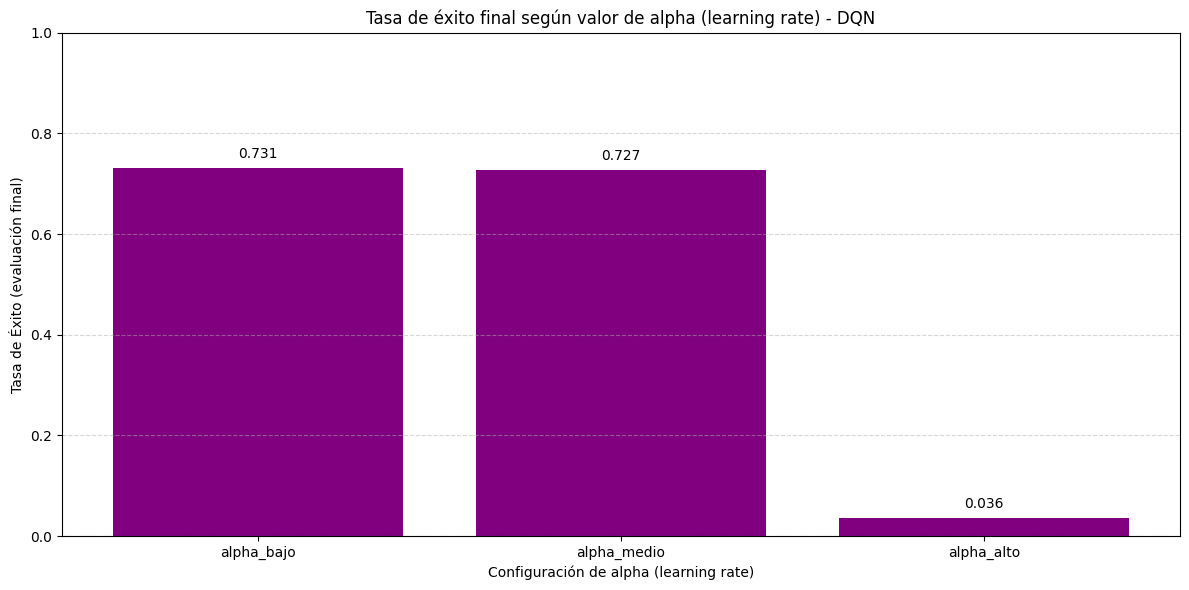

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# === Gráfico barras tasa de éxito final para distintos alphas ===
nombres_alpha = [r.nombre for r in resultados_dqn_alpha]
tasas_alpha = [r.tasa_6000 for r in resultados_dqn_alpha]

plt.figure(figsize=(12, 6))
bars = plt.bar(nombres_alpha, tasas_alpha, color='purple')
plt.title("Tasa de éxito final según valor de alpha (learning rate) - DQN")
plt.xlabel("Configuración de alpha (learning rate)")
plt.ylabel("Tasa de Éxito (evaluación final)")
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar, tasa in zip(bars, tasas_alpha):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f"{tasa:.3f}", ha='center')

plt.tight_layout()
plt.show()

### **Evolución de la recompensa por episodio (suavizada) según alpha (learning rate) - DQN**

En este gráfico se observa la recompensa media que el agente DQN obtiene a lo largo del entrenamiento, suavizada para facilitar la visualización de las tendencias.

- Cada línea representa un valor distinto de alpha (learning rate).
- El eje horizontal muestra el número de episodios.
- El eje vertical indica la recompensa media en una ventana de 100 episodios.

**Interpretación:**

- Una curva ascendente y estable indica que el agente está aprendiendo de manera efectiva y constante.
- Curvas con muchas fluctuaciones o que se mantienen bajas reflejan aprendizaje inestable o deficiente.
- Comparando las curvas, se puede identificar qué valor de alpha conduce a un mejor desempeño y estabilidad durante el entrenamiento.

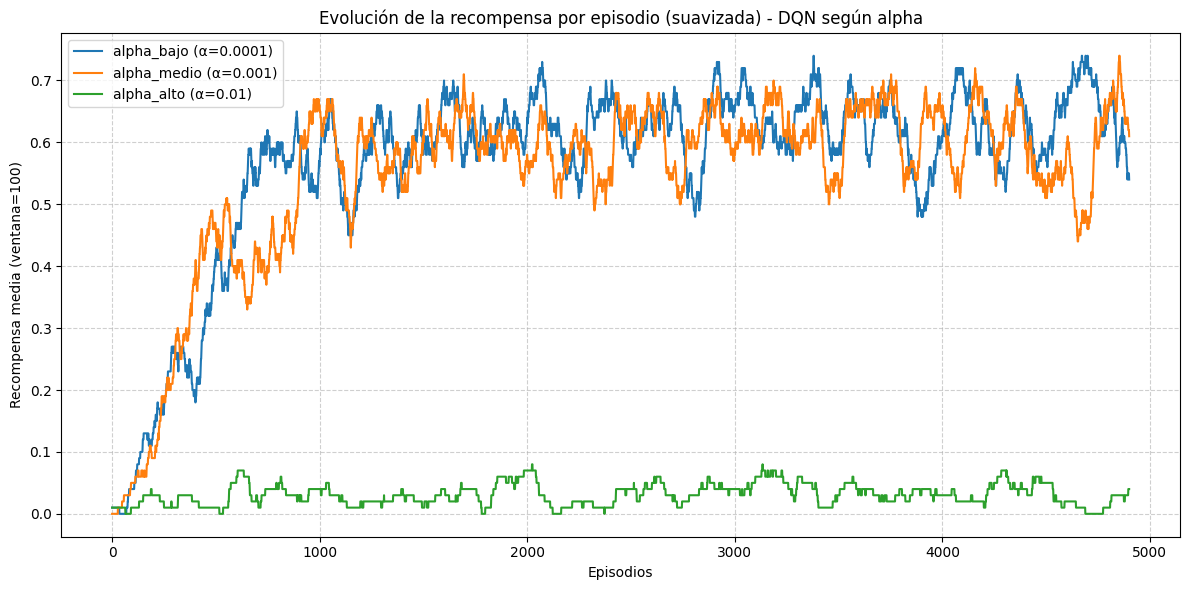

In [ ]:
# === Gráfico evolución recompensa suavizada por alpha ===
def moving_average(data, window=100):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12, 6))

for r in resultados_dqn_alpha:
    recomp_suavizada = moving_average(r.recompensas)
    plt.plot(recomp_suavizada, label=f"{r.nombre} (α={r.alpha})")

plt.title("Evolución de la recompensa por episodio (suavizada) - DQN según alpha")
plt.xlabel("Episodios")
plt.ylabel("Recompensa media (ventana=100)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

----------
## **Comparación de tasa de éxito a 6000 episodios: Agentes tradicionales vs DQN con hiperparámetros optimizados**

Este gráfico muestra la tasa de éxito final alcanzada por distintos agentes luego de 6000 episodios de entrenamiento:

- **Aleatorio:** Política sin aprendizaje, con tasa cercana a 0.
- **Q-Learning:** Agente basado en tabla Q con buen desempeño.
- **DQN base:** Deep Q-Network con configuración inicial.
- **DQN γ=0.99:** DQN ajustado con un valor alto del factor de descuento (gamma).
- **DQN α=0.001:** DQN con tasa de aprendizaje (alpha) media optimizada.

**Interpretación:**

- Se puede apreciar que los agentes con aprendizaje (Q-Learning y DQN) superan ampliamente a la política aleatoria.
- El ajuste de hiperparámetros gamma y alpha mejora el desempeño del DQN respecto a su configuración base.
- Esto evidencia la importancia de seleccionar cuidadosamente los valores de gamma y alpha para optimizar el rendimiento del agente en tareas de aprendizaje por refuerzo.

En resumen, el gráfico permite visualizar cómo diferentes configuraciones impactan la capacidad de aprendizaje y éxito del agente.

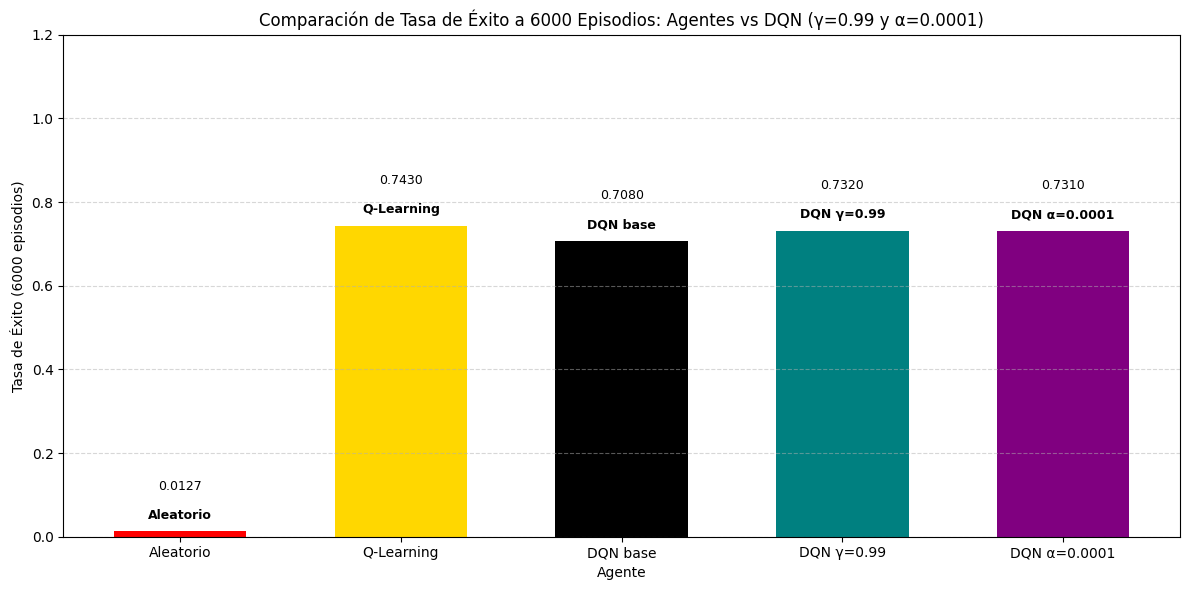

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# === Datos ===
# Tasa de éxito final de cada agente a los 6000 episodios
tasa_aleatorio = tasa_exito_aleatorio_6000
tasa_qlearning = tasa_q_6000
tasa_dqn_base = tasa_dqn_6000

# Buscar resultado de DQN con gamma alto
gamma_alto_resultado = next(r for r in resultados_dqn_gamma if np.isclose(r.gamma, 0.99))
tasa_dqn_gamma_alto = gamma_alto_resultado.tasa_6000

# Buscar resultado de DQN con alpha medio (por ejemplo 0.001)
alpha_medio_resultado = next(r for r in resultados_dqn_alpha if np.isclose(r.alpha, 0.001))
tasa_dqn_alpha_medio = alpha_medio_resultado.tasa_6000

# Buscar resultado de DQN con alpha bajo (0.0001), que es el que rindió mejor
alpha_bajo_resultado = next(r for r in resultados_dqn_alpha if np.isclose(r.alpha, 0.0001))
tasa_dqn_alpha_bajo = alpha_bajo_resultado.tasa_6000

# Agentes y tasas
agentes = ['Aleatorio', 'Q-Learning', 'DQN base', 'DQN γ=0.99', 'DQN α=0.0001']
tasas = [tasa_aleatorio, tasa_qlearning, tasa_dqn_base, tasa_dqn_gamma_alto, tasa_dqn_alpha_bajo]

# === Gráfico ===
x = np.arange(len(agentes))
plt.figure(figsize=(12, 6))
barras = plt.bar(x, tasas, color=['red', 'gold', 'black', 'teal', 'purple'], width=0.6)

# Etiquetas arriba
for i, barra in enumerate(barras):
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width() / 2, altura + 0.03, agentes[i], ha='center', fontsize=9, fontweight='bold')
    plt.text(barra.get_x() + barra.get_width() / 2, altura + 0.10, f"{altura:.4f}", ha='center', fontsize=9)

# Estética
plt.xticks(x, agentes)
plt.xlabel('Agente')
plt.ylabel('Tasa de Éxito (6000 episodios)')
plt.title('Comparación de Tasa de Éxito a 6000 Episodios: Agentes vs DQN (γ=0.99 y α=0.0001)')
plt.ylim(0, 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### **📌 Conclusión general – Comparación entre agentes y efecto de ALPHA en DQN**

La comparación final de la **tasa de éxito a los 6000 episodios** muestra que:

- El agente **DQN con alpha bajo (α = 0.0001)** alcanzó una tasa de éxito del **0.731**, muy similar al **DQN con gamma alto (γ = 0.99)** con **0.732** y al **Q-Learning clásico** con **0.743**.

- El **DQN base**, sin ajuste de hiperparámetros, quedó levemente por debajo con **0.708**.

- La **política aleatoria**, como se esperaba, tuvo un rendimiento muy bajo (**0.0127**).

👉 Esto sugiere que **una tasa de aprendizaje pequeña (alpha bajo)** mejora significativamente el rendimiento del agente DQN, permitiendo una convergencia más estable y efectiva.

📈 En resumen, tanto el ajuste de **γ/GAMMA** como de **α/ALPHA** resultaron beneficiosos para el aprendizaje del agente, destacando la importancia de **ajustar hiperparámetros clave** para optimizar el rendimiento en entornos de aprendizaje por refuerzo profundo.

🔍 Sin embargo, es importante remarcar que el Q-Learning obtuvo la mejor tasa de éxito global, lo que indica que, para este entorno y configuración, la simplicidad del enfoque tabular puede superar incluso a métodos más complejos como DQN, especialmente si estos no están cuidadosamente ajustados o requieren mayor capacidad de exploración/aprendizaje.
_____________
________________

## 📚 Referencias y consultas realizadas

### Reproducibilidad y estabilidad en los resultados

**Prompt GPT:**  
*Estoy teniendo problemas con la reproducibilidad en mi entrenamiento de DQN usando PyTorch y Gym, específicamente en el entorno FrozenLake. Cada vez que ejecuto el código, los resultados cambian y no puedo comparar bien. ¿Cómo puedo fijar semillas para asegurar que los resultados sean deterministas?*


**Acumulación progresiva de episodios de entrenamiento**

*¿Qué consideraciones debo tener para acumular episodios de entrenamiento en DQN sin perder consistencia en los resultados? Por ejemplo, si ya entrené 1000 episodios, ¿cómo continuar hasta 3000 o 6000 manteniendo la coherencia en el aprendizaje y la convergencia del agente?*


**Visualización y análisis gráfico de resultados**

*¿Qué tipos de gráficos son recomendables para mostrar la evolución de la recompensa y la tasa de éxito en agentes DQN con variaciones en los hiperparámetros gamma y alpha?*


**Generación de gráficos**

- **Comparación de tasa de éxito entre agentes**  
  *¿Cómo puedo generar un gráfico de barras que muestre la tasa de éxito final a los 6000 episodios para política aleatoria, Q-Learning, DQN base y variantes con γ y α?*

- **Evolución de la recompensa por episodio (suavizada)**  
  *¿Cómo graficar la evolución de la recompensa promedio por episodio usando un suavizado por promedio móvil (ventana=100), para observar la convergencia en distintas configuraciones de alpha o gamma?*

- **Impacto del hiperparámetro gamma (γ)**  
  *¿Cómo visualizar gráficamente cómo afecta el valor de gamma (por ejemplo γ=0.99) al desempeño del DQN, comparando tasa de éxito final y estabilidad del aprendizaje?*

- **Impacto del hiperparámetro alpha (α)**  
  *¿Cómo puedo graficar el efecto de diferentes valores de alpha (como α = 0.0001, 0.001, 0.01) en el rendimiento y la convergencia del DQN?*